Write a program in python to implement the full Bayesian inference on Gaussian variables for curve fitting problem. Follow the instructions below:



1. Generate 50 2D-data points using the following function: $y = \sin(x^2+1)$
2. Add Gaussian random noise to the data
3. Show the original curve line and the noisy data.

[0, 1, 0.75, 1.1]

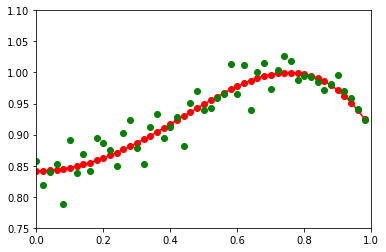

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import random
import math

# Define the sin function that returns the original data
def sin_distribution():
    # create x coordinates in interval [0,1), with increment 0.02
    x = np.arange(0,1,0.02);
    # create y coordinates according to given function
    y = np.sin(np.power(x,2) + 1)
    return x,y

# Define a function that adds noise to y-values of our original function
def add_noise(y_curve, mu, sigma):
    # Create a normal distribution of noisy values corresponding to y values
    noise = np.random.normal(mu, sigma, len(y_curve))
    # Create new y values by adding noise 
    y_noise = y_curve + noise
    return y_noise

# Set constant variables:
# sigma: the sigma value we use for the Gaussian distribution
sigma = 0.03
# x: the NX1 vector of original x-values
x = sin_distribution()[0]
N = len(x)
# y: the Nx1 vector of original y-values
y = sin_distribution()[1]
# t_bar: the Nx1 vector with our ground truth (noisy y-values)
t_bar = add_noise(y, 0, sigma)

# Actual curve plotted in red line
plt.plot(x, sin_distribution()[1], "r")
plt.plot(x, sin_distribution()[1], "ro")
# Noisy values plotted in green points
plt.plot(x, t_bar, "go")
plt.axis([0,1,0.75,1.1])

4. Compute the Gaussian process prediction of every input data sequentially, where each input data is taken randomly from the noise data.
5. Use the kernel we discuss in class (textbook's Eq. (6.63), page 307), by setting thetas: (1.0, 4.0, 0.0, 0.0)

In [62]:
def ker(theta0, theta1, theta2, theta3, xi, xj):
    # Inputs: xi and xj are type int
    # Returns output of type int 
    return theta0*np.exp(-theta1/2 *  np.power(np.linalg.norm(xi-xj), 2)) + theta2 + theta3*xi*xj

def Kmat(theta0, theta1, theta2, theta3, xn):
    # Inputs: xn is type ndarray with dimension NX1
    # Returns output of type ndarray with dimensions NxN
    if type(xn) == int:
        return np.array[[(ker(theta0,theta1,theta2,theta3,xn, xn))]]
    else:
        mat = np.zeros(len(xn))
        for j in range(len(xn)):
            row = np.zeros(len(xn))
            for i in range(len(xn)):
                row[i] = ker(theta0,theta1,theta2,theta3, x[i], x[j])
            mat = np.vstack([mat, row])
        mat = np.delete(mat,0,0)
        return mat

def update(theta0, theta1, theta2, theta3, xn, beta,tbar):
    index = np.arange(50)
    np.random.shuffle(index)   
    
    # Base case: For
    # n is the number of data points so far, and the dimension of our C matrix
    n = 1
    # Base case: Initialise C and k*
    # Choose a random x and set it as t_star
    x_star = xn[index[0]]

    # Plot!
    plt.figure()
    plt.title("Beta = " + str(beta) + ", N = " + str(n)+", new data = x[" + str(x_star) + "]")
    # Actual curve plotted in red line
    plt.plot(xn, sin_distribution()[1], "r")
    # Noisy values plotted in green points
    plt.plot(xn, t_bar, "go")
    
    # Initialise cstar, kstar, Cmat, xn_update and tbar_update
    xn_update = np.array([x_star])
    tbar_update = np.array(tbar[index[0]])

    for l in range(len(xn)):
        cstar = ker(theta0, theta1, theta2, theta3,  x_star, x_star) + 1/beta
        kstar = ker(theta0, theta1, theta2, theta3, xn[l], x_star)
        Cmat = cstar
        
        Ustar = kstar*(1/Cmat)*tbar[index[0]]
        Covstar = Cmat - kstar*(1/Cmat)*kstar
        plt.errorbar(xn[l], Ustar, yerr=(Covstar), fmt = 'o',ecolor='b')
    
    # When we are done plotting base case, make Cmat and kstar into 1x1 singletons
    Cmat = np.array([[Cmat]])
    
    # CHANGE TO 1:50 EVENTUALLY
    for i in index[1:50]:  
        
        # Plot current data
        plt.figure()
        plt.title("Beta = " + str(beta) + ", N = " + str(n)+", new data = x[" + str(x_star) + "]")
        # Actual curve plotted in red line
        plt.plot(xn, sin_distribution()[1], "r")
        # Noisy values plotted in green points
        plt.plot(xn, t_bar, "go")
        
        # Update n
        n+=1
        
        # Reassign x_star - SCALAR
        x_star = xn[index[i]]
        
        # Update tbar_update
        tbar_update = np.append(tbar_update, tbar[index[i]])

        # Update kstar (for Cmat) - 1xN
        kstar = np.array([[]])
        for xi in xn_update:
            kstar = np.append(kstar, ker(theta0, theta1, theta2, theta3, np.array([xi]), x_star))
        
        # Update cstar (for Cmat) - SCALAR
        cstar = ker(theta0, theta1, theta2, theta3,  x_star, x_star) + 1/beta
        # Update Cmat

        Cmat = np.vstack([Cmat, kstar])
        zerocol = np.zeros((Cmat.shape[0],1))
        Cmat = np.append(Cmat, zerocol, axis = 1)
        Cmat[Cmat.shape[0]-1,Cmat.shape[0]-1] = cstar

        for c in range(n-1):
            Cmat[c,Cmat.shape[0]-1] = kstar[c]
            Cmat[Cmat.shape[0]-1,c] = kstar[c]

        # Update xn
        xn_update = np.append(xn_update, x_star)
    
        # Calculate predictions for current data
        for l in range(len(xn)):
            # Calculate kstar_temp and cstar_temp for xstar from x1 to xn_update
            
            # cstar = k(x*, x*) - 1x1
            cstar_temp = ker(theta0, theta1, theta2, theta3,  xn[l], xn[l]) + 1/beta
            
            # kstar = k(xi, x*) - 1xN
            kstar_temp = np.array([[]])
            for xi in xn_update:
                kstar_temp = np.append(kstar_temp, ker(theta0, theta1, theta2, theta3, xi, xn[l]))
            # Calculate Cmat for xstar from from x1 to xn_update
            Ustar = np.dot(np.dot(kstar_temp, np.linalg.inv(Cmat)), tbar_update)

            Covstar = cstar_temp - np.dot(np.dot(kstar_temp, np.linalg.inv(Cmat)), kstar_temp)
            plt.errorbar(xn[l], Ustar, yerr=np.sqrt(Covstar), fmt = 'o',ecolor='b')

6. Experiment with your code by changing beta, and explain what beta is for and how it affects the results.

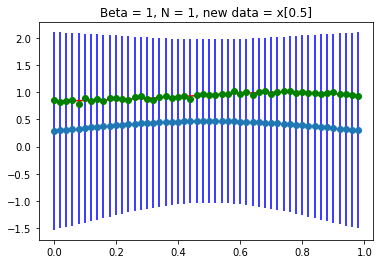

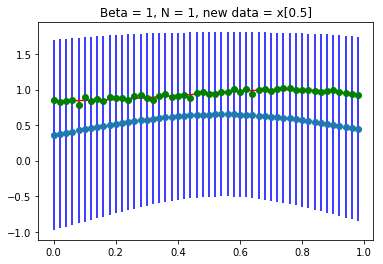

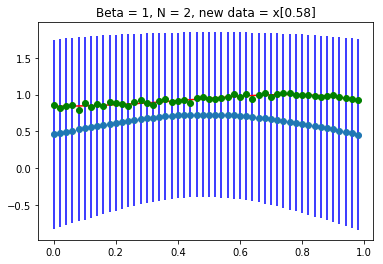

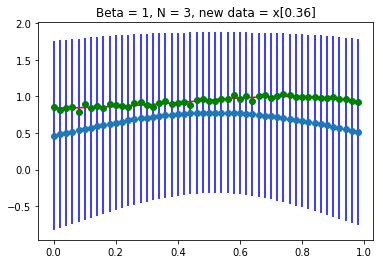

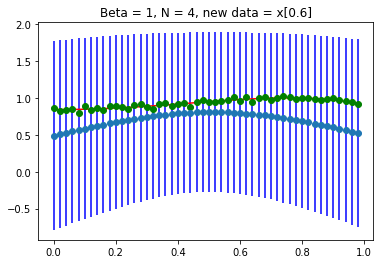

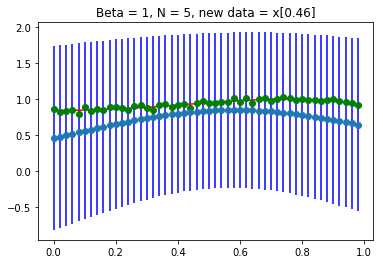

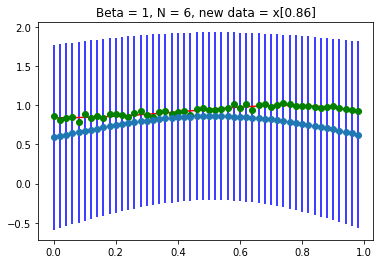

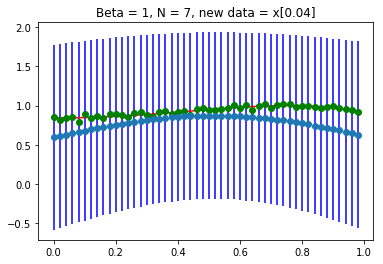

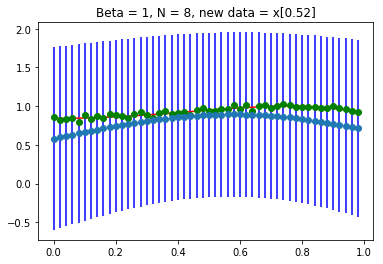

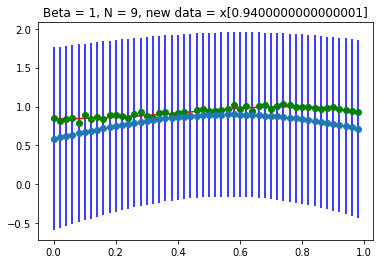

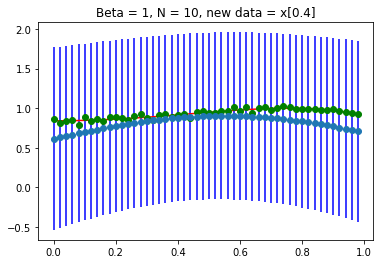

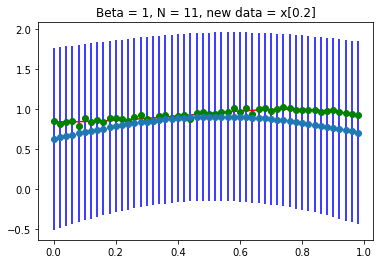

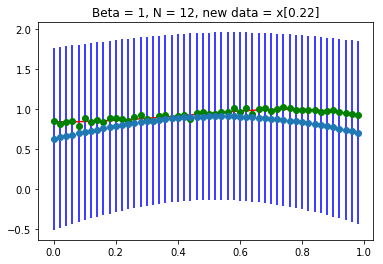

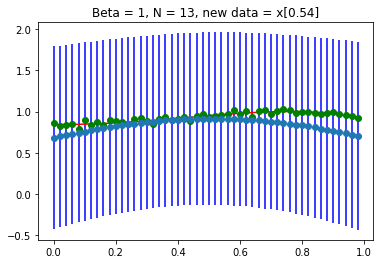

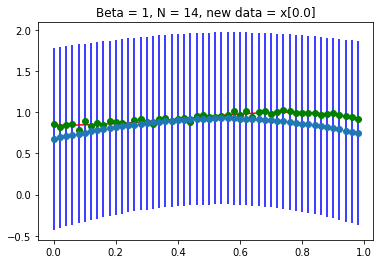

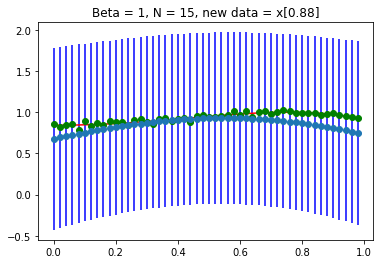

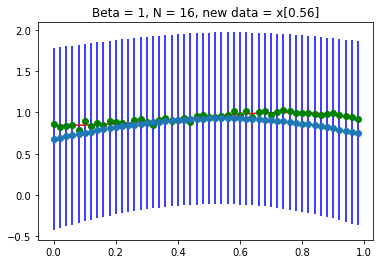

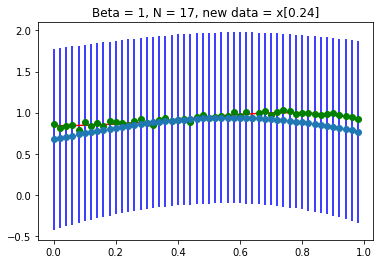

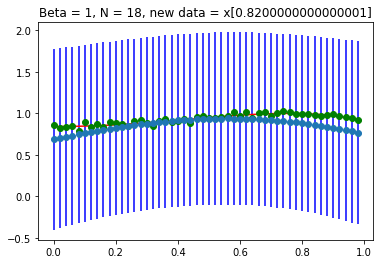

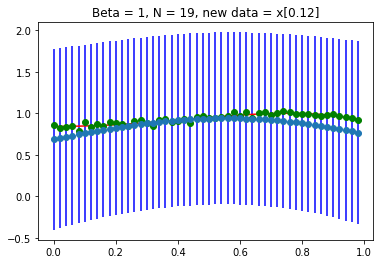

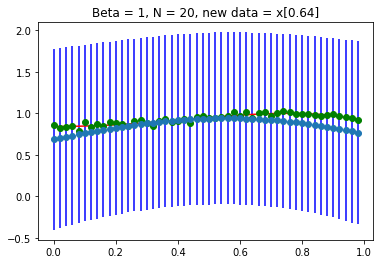

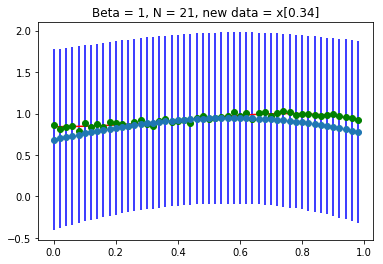

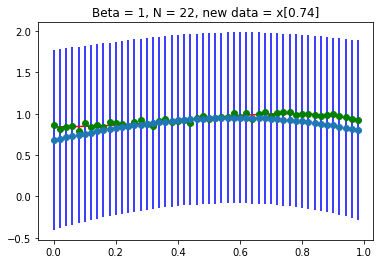

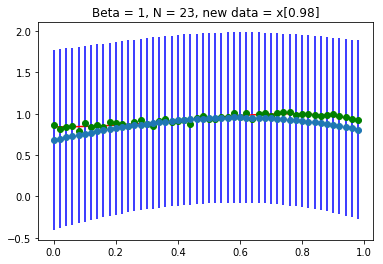

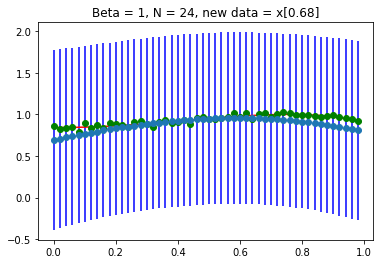

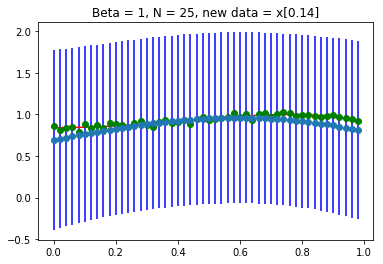

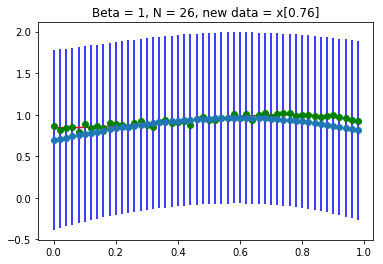

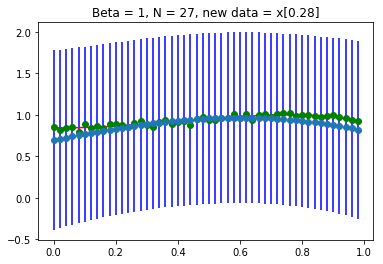

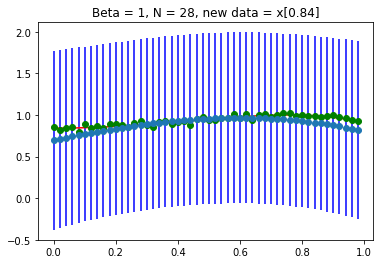

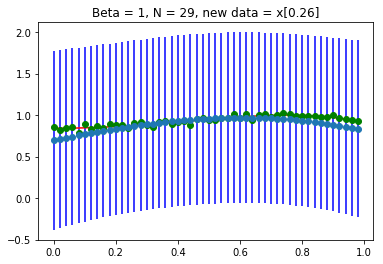

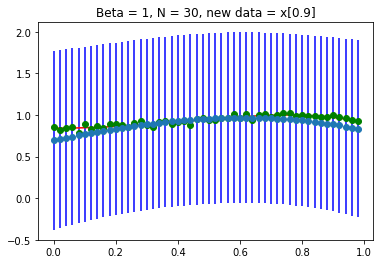

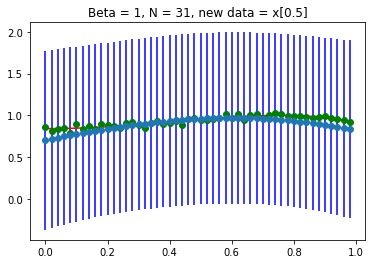

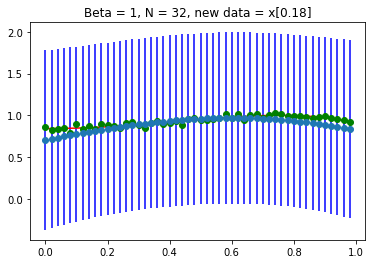

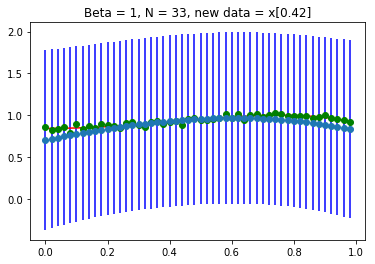

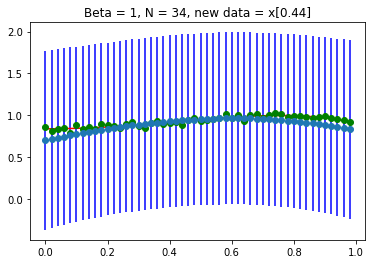

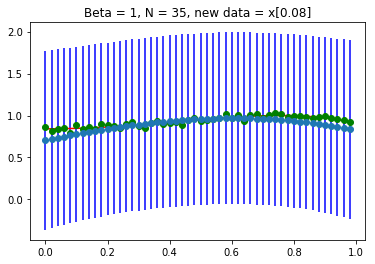

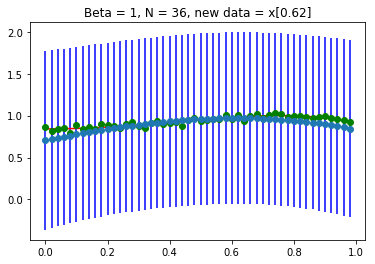

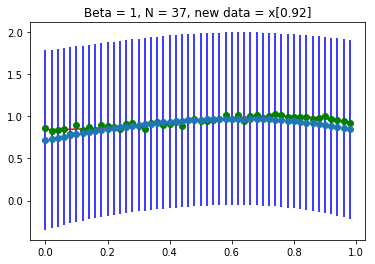

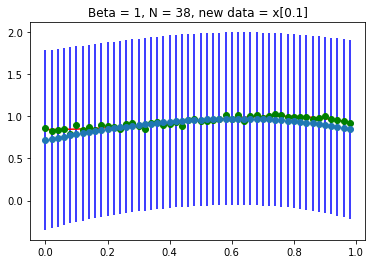

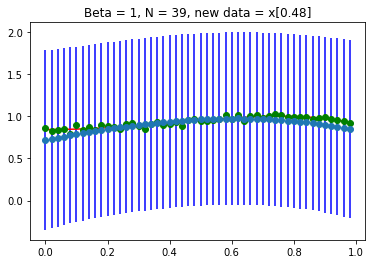

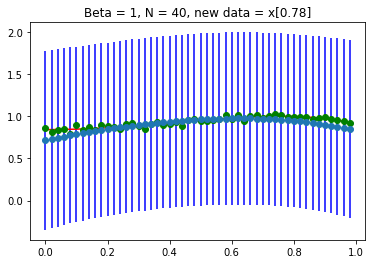

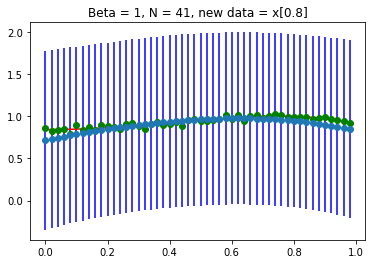

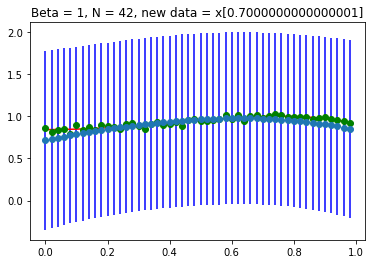

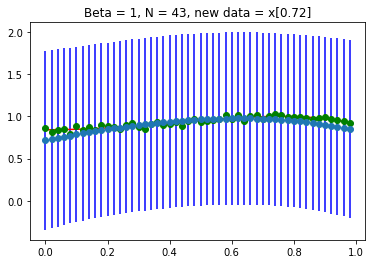

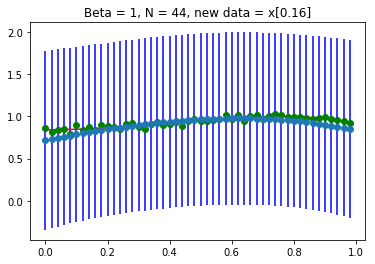

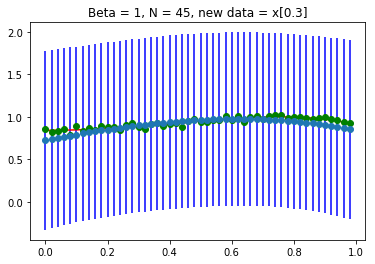

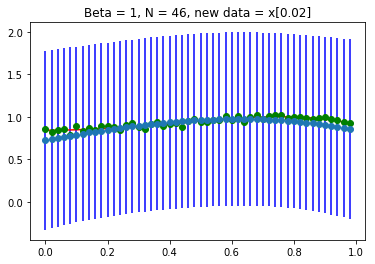

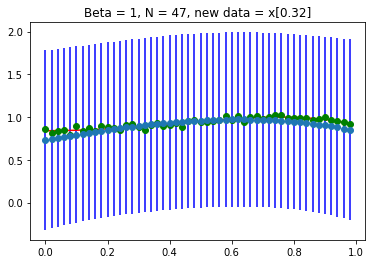

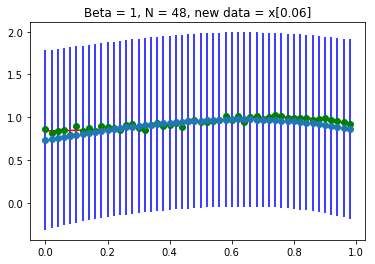

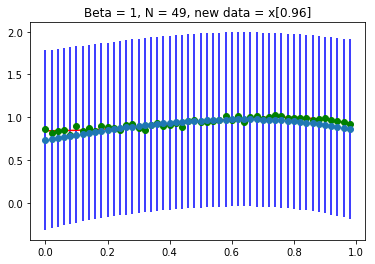

In [64]:
b = 1
update(1.0, 4, 0, 0, x, b, t_bar)

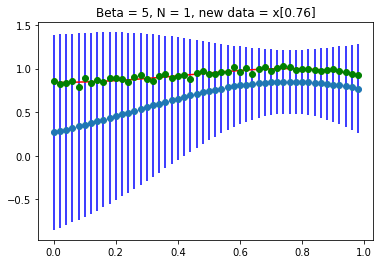

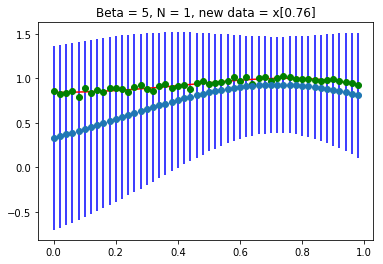

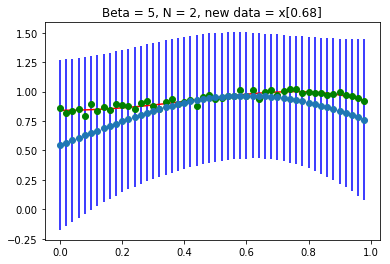

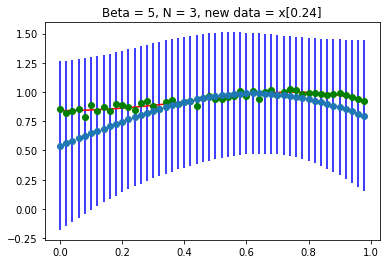

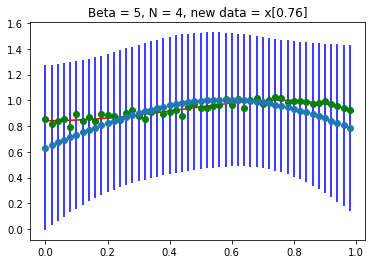

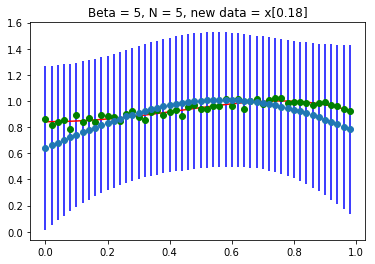

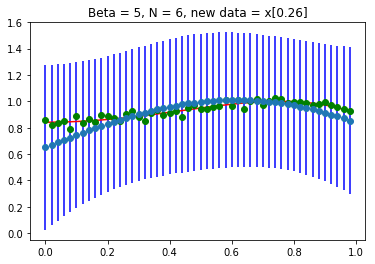

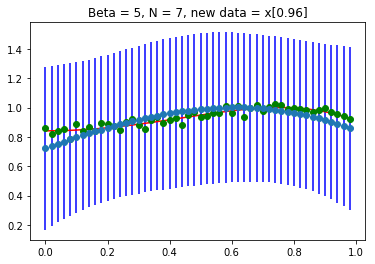

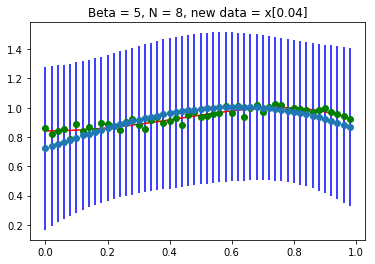

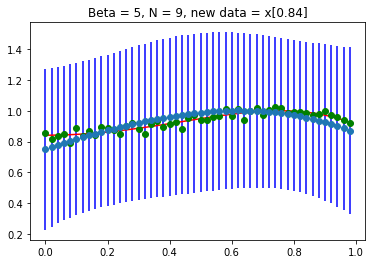

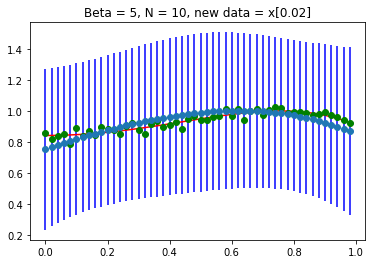

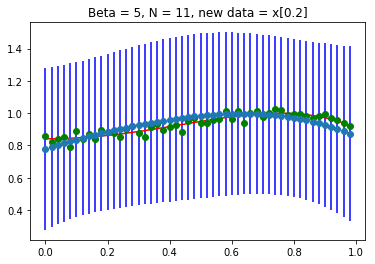

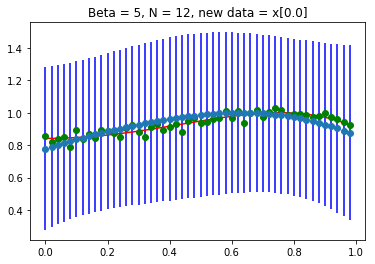

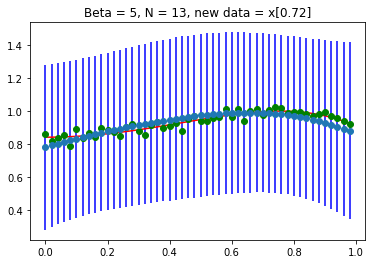

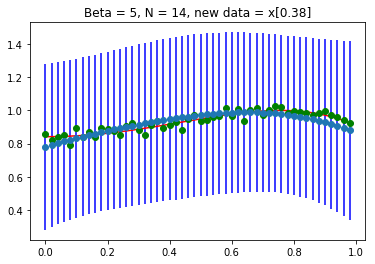

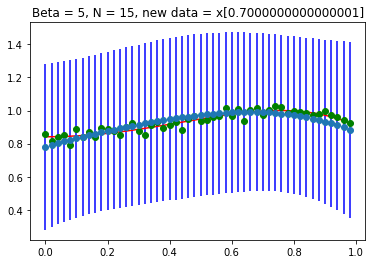

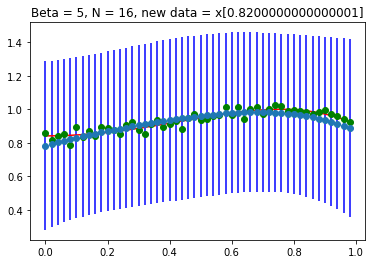

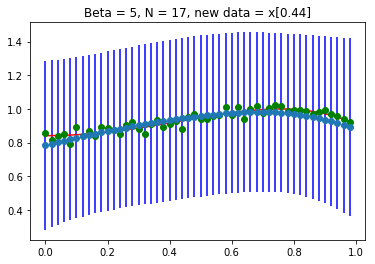

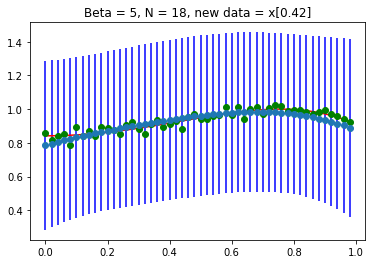

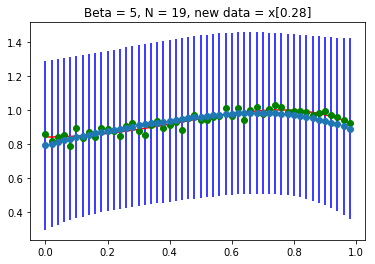

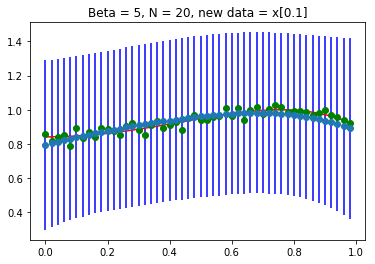

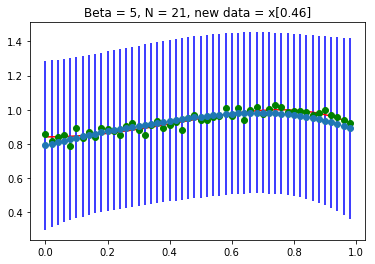

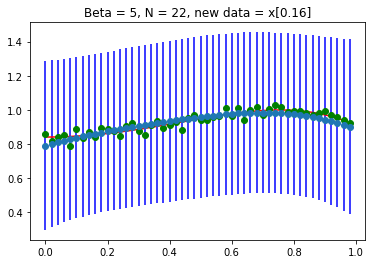

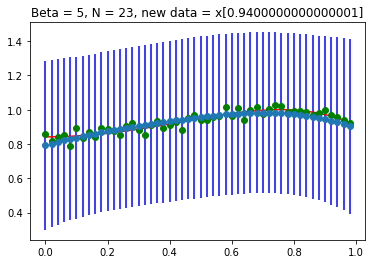

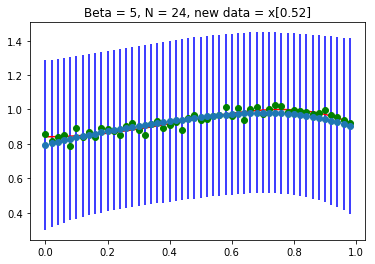

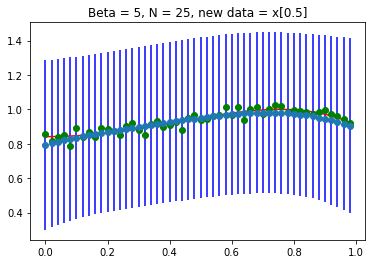

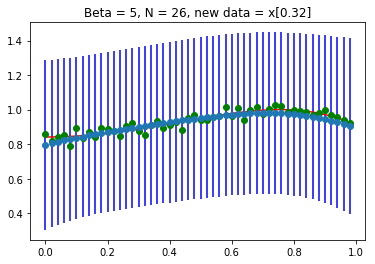

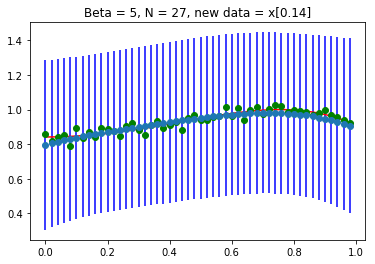

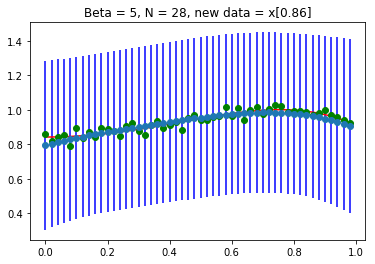

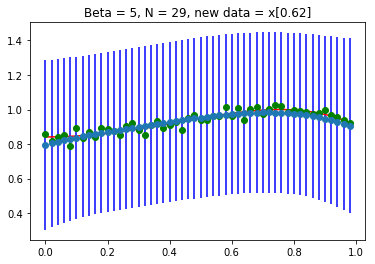

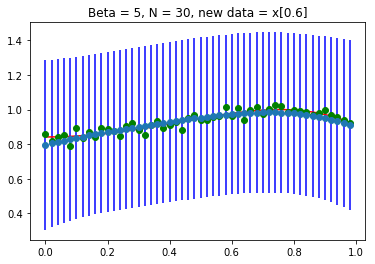

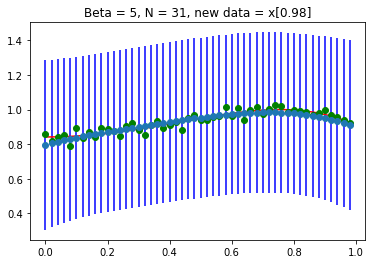

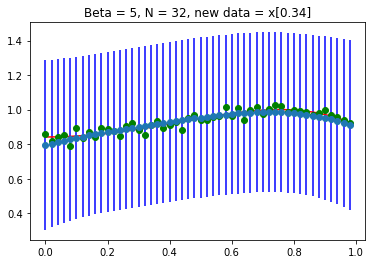

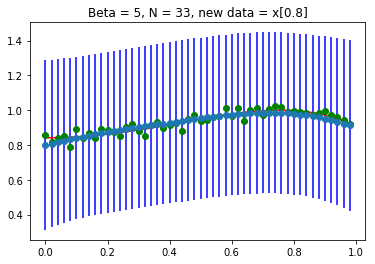

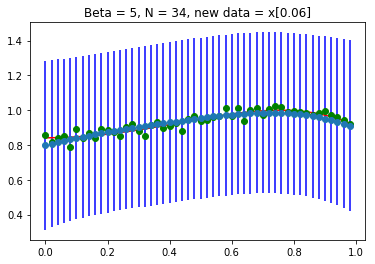

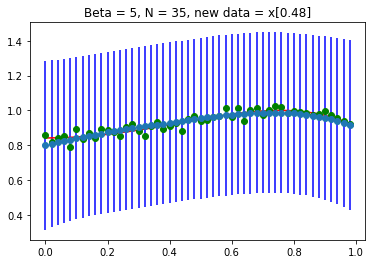

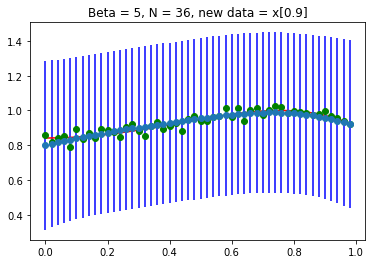

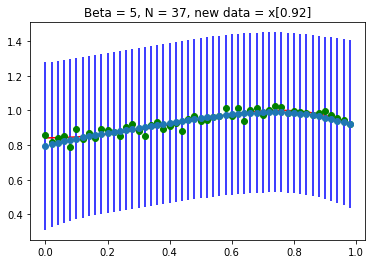

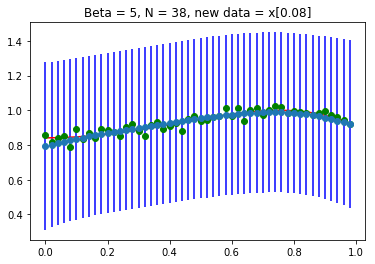

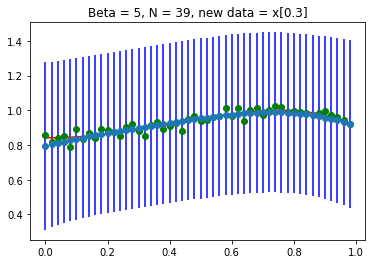

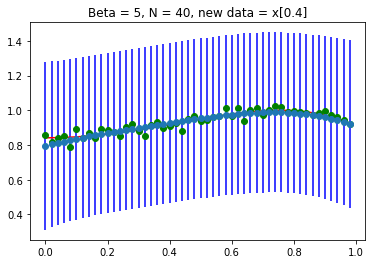

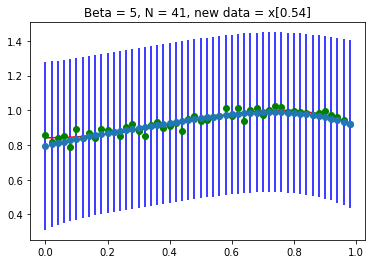

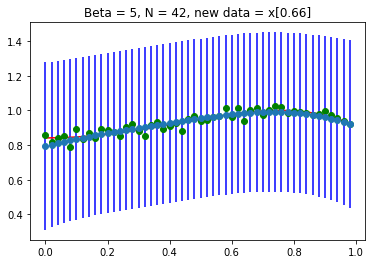

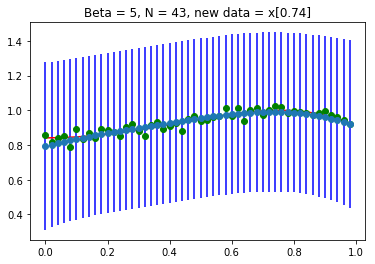

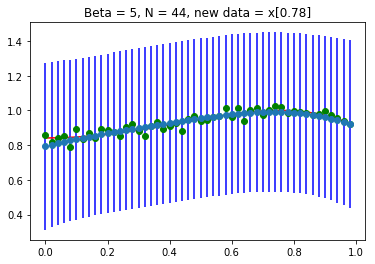

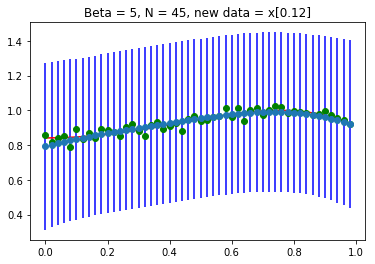

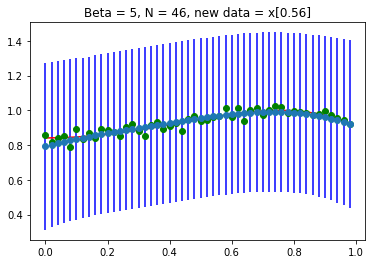

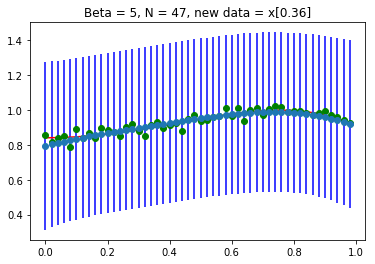

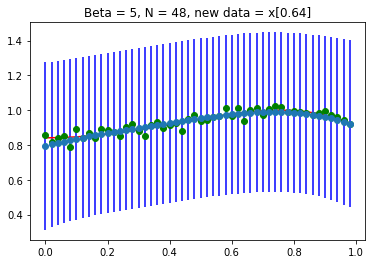

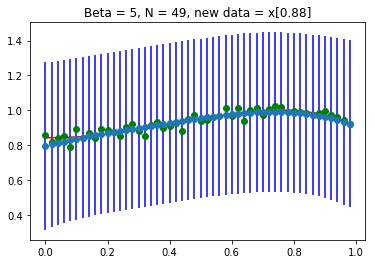

In [67]:
b = 5
update(1.0, 4, 0, 0, x, b, t_bar)

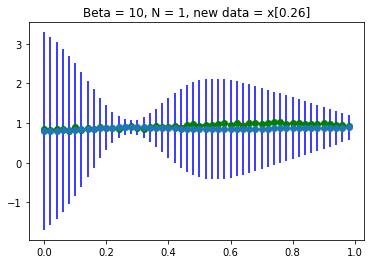

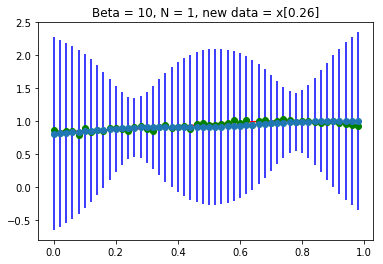

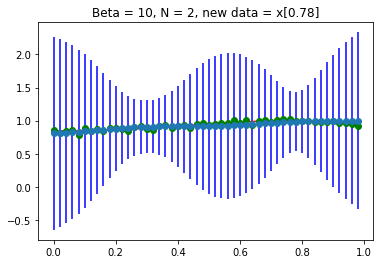

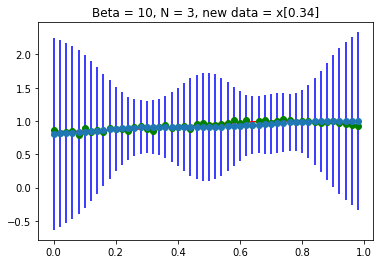

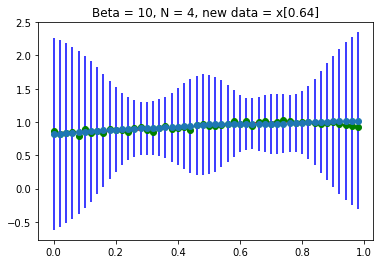

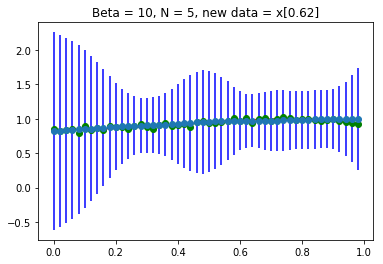

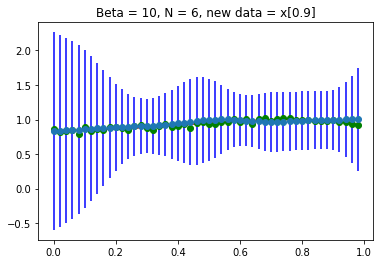

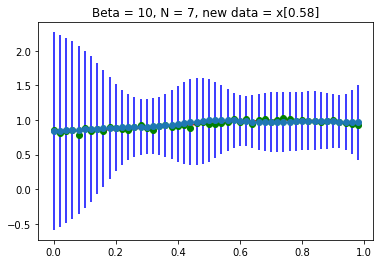

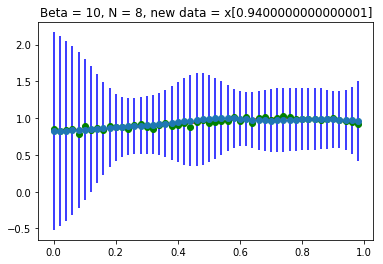

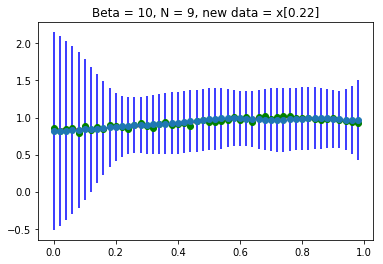

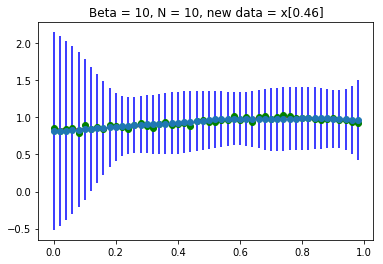

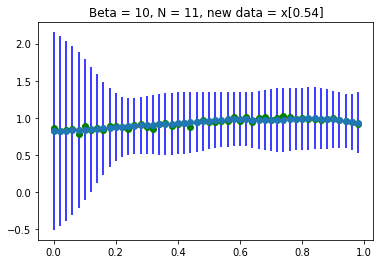

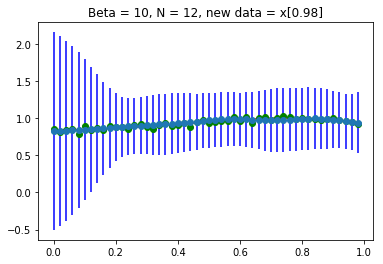

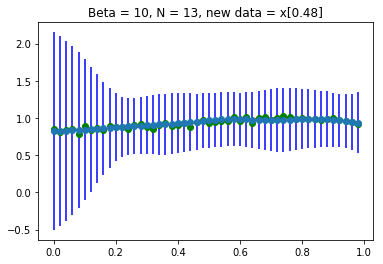

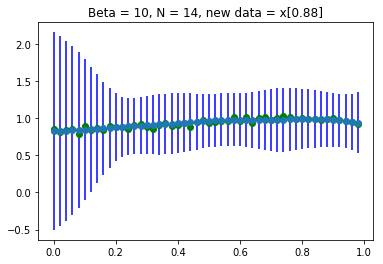

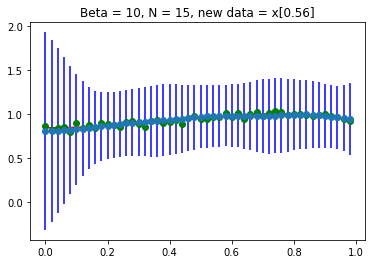

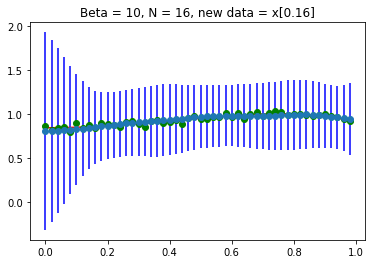

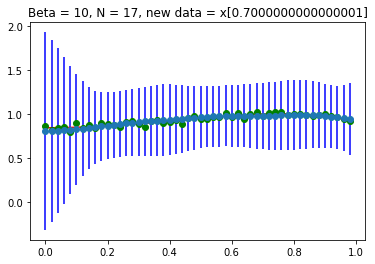

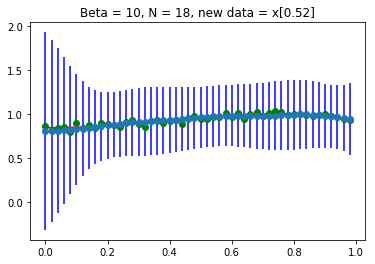

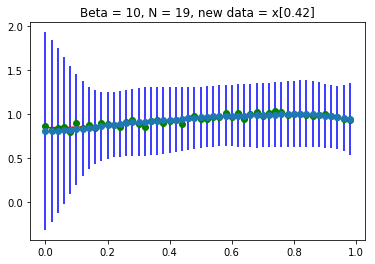

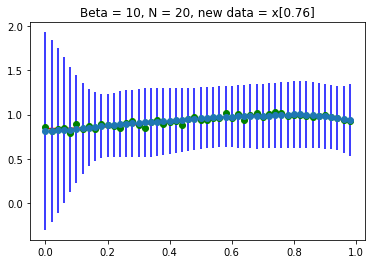

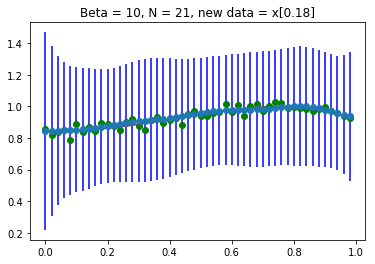

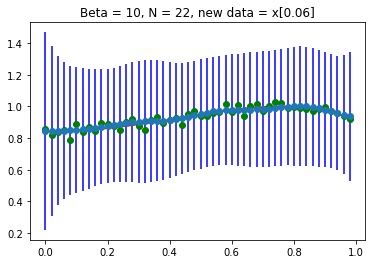

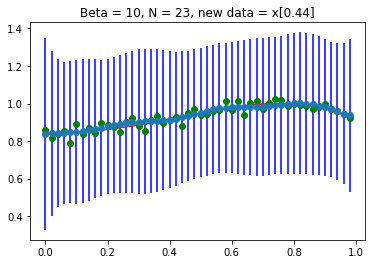

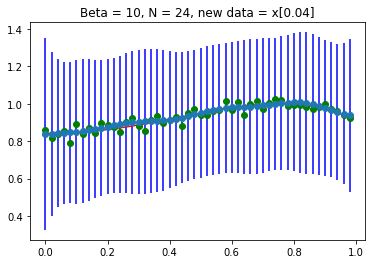

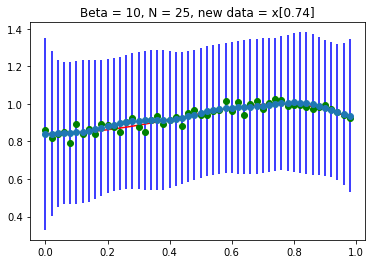

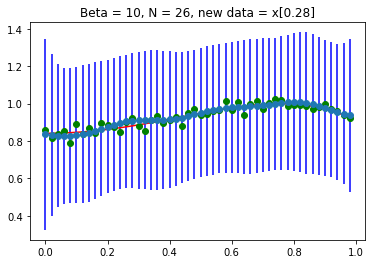

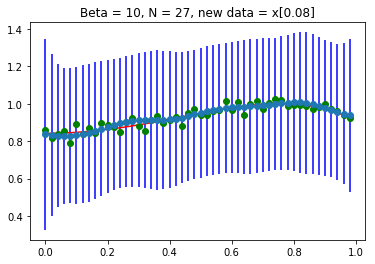

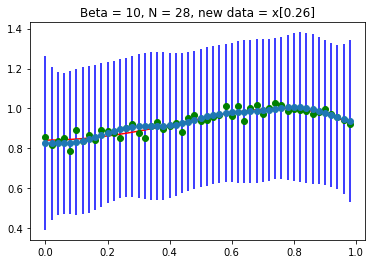

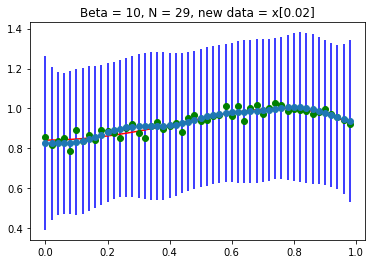

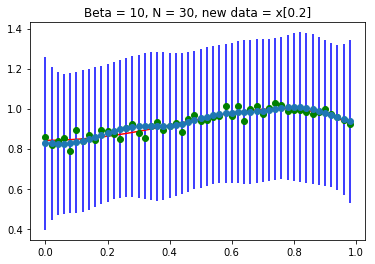

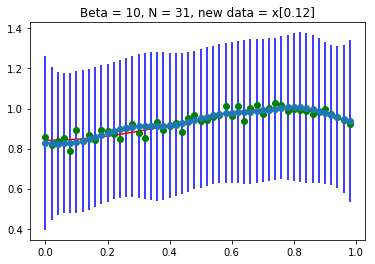

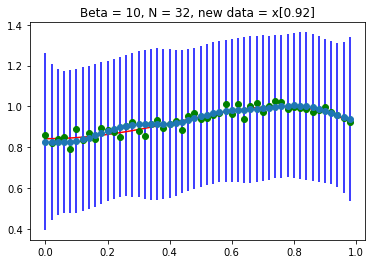

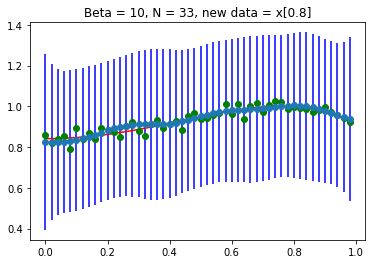

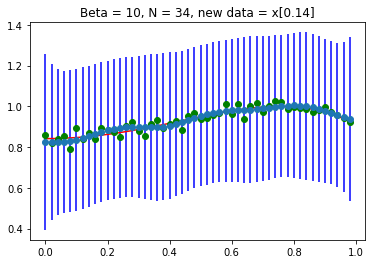

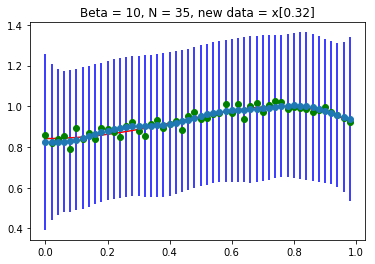

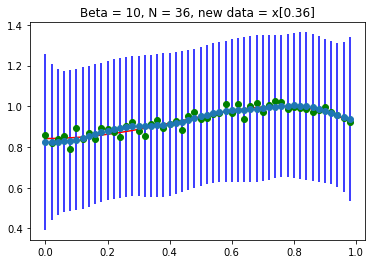

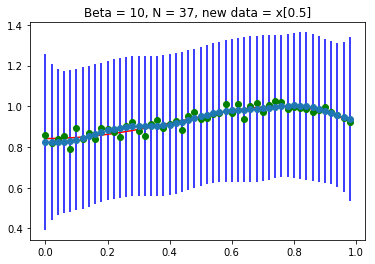

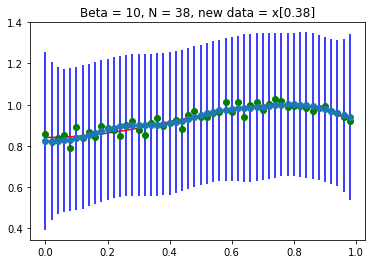

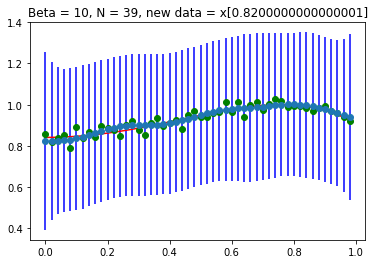

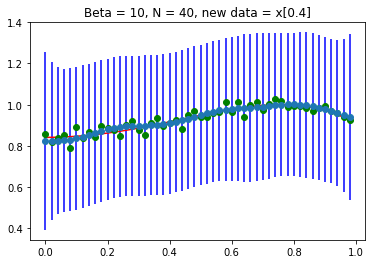

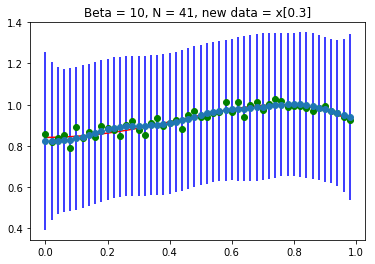

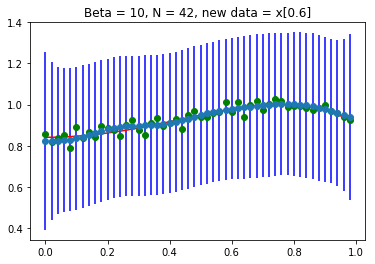

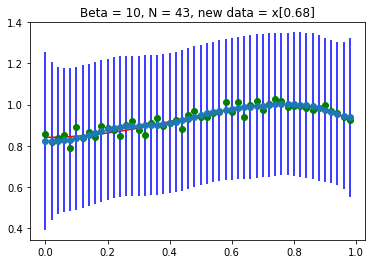

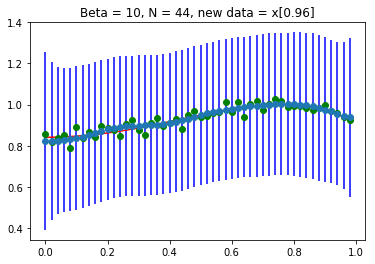

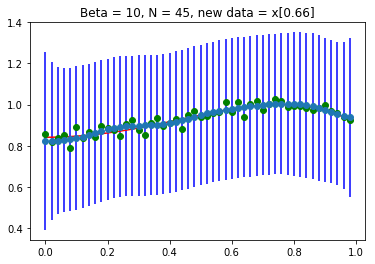

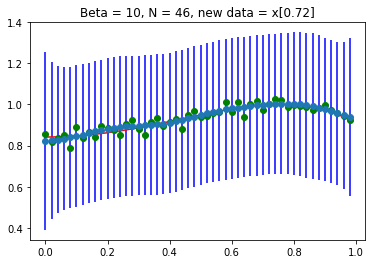

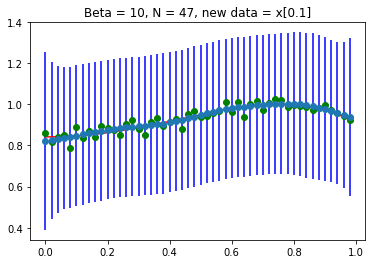

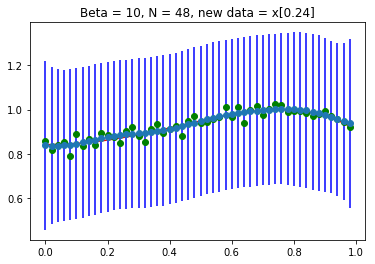

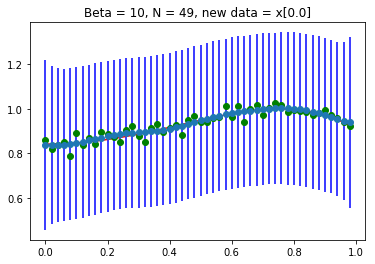

In [68]:
b = 10
update(1.0, 64, 10, 5, x, b, t_bar)

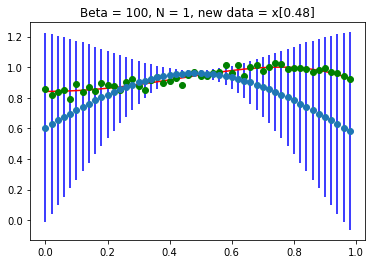

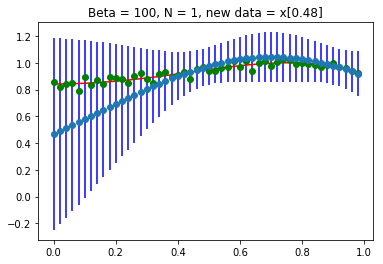

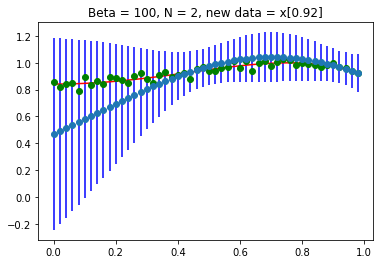

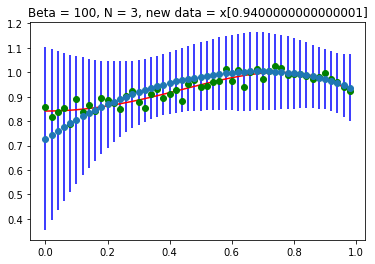

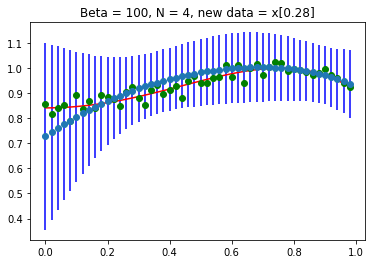

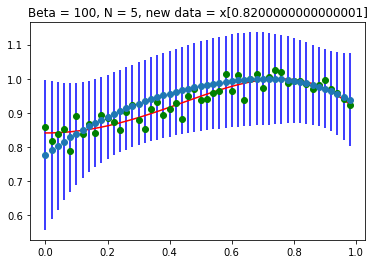

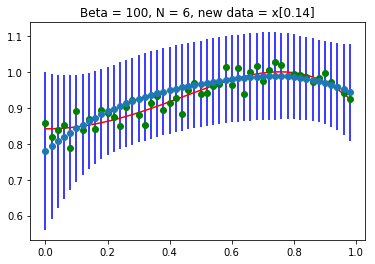

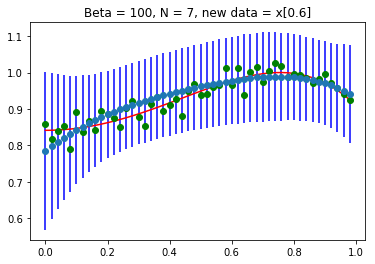

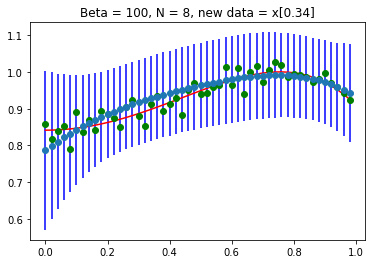

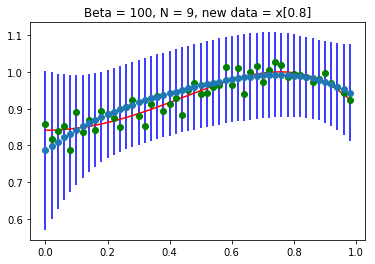

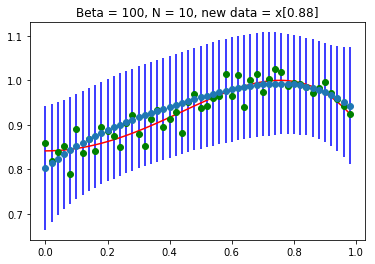

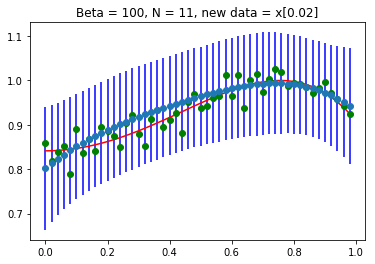

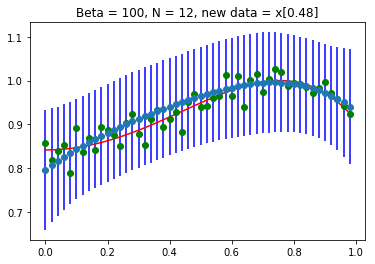

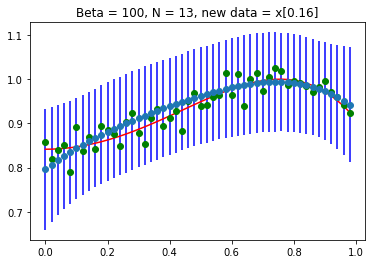

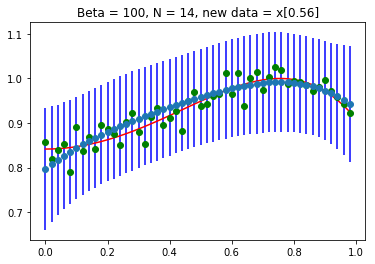

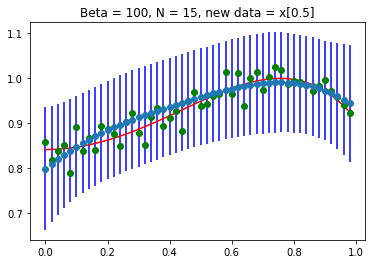

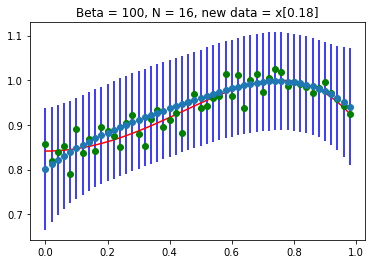

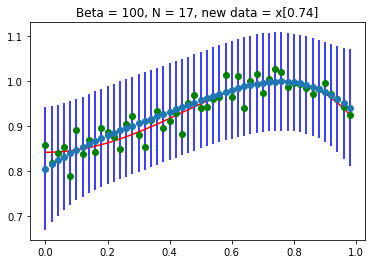

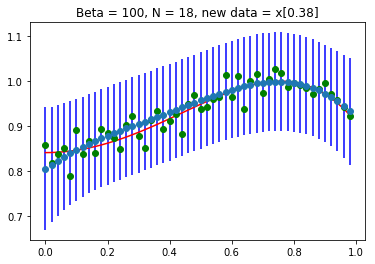

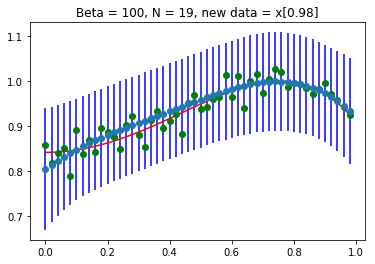

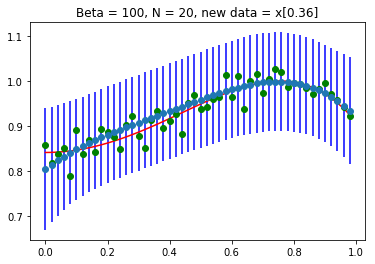

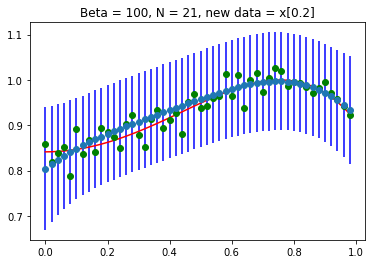

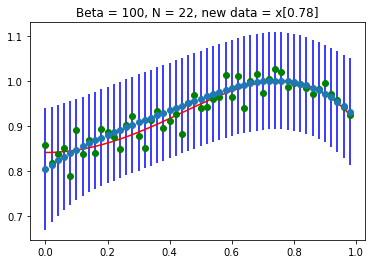

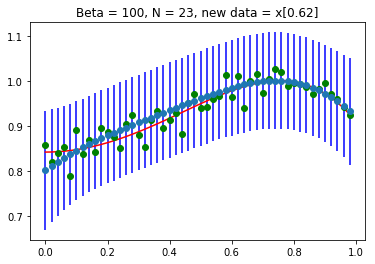

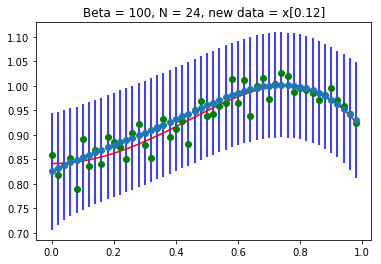

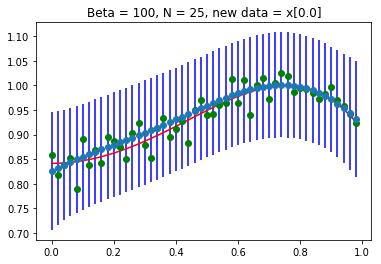

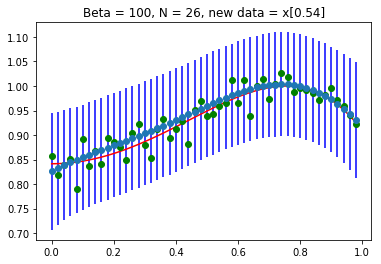

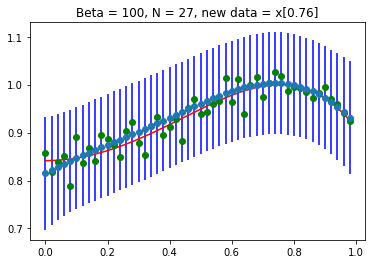

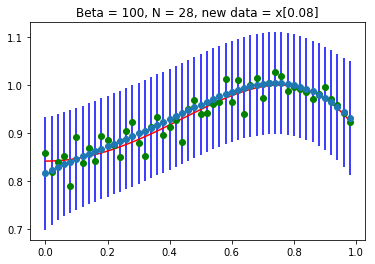

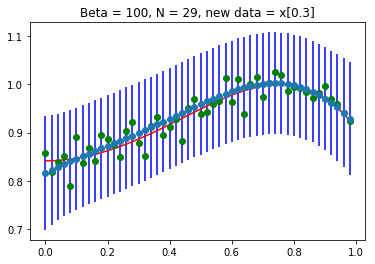

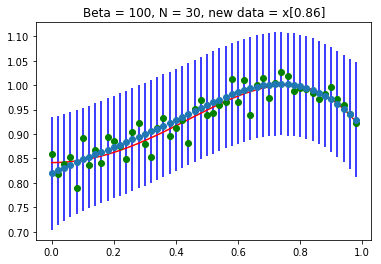

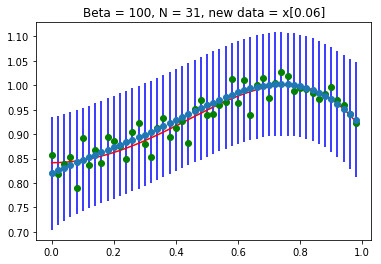

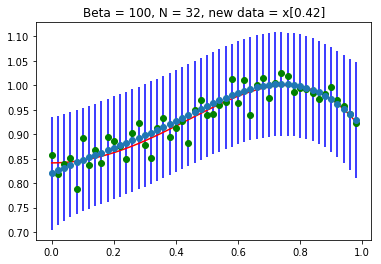

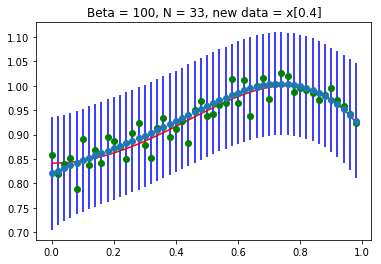

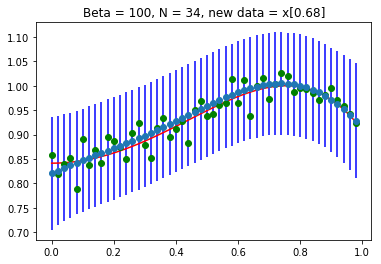

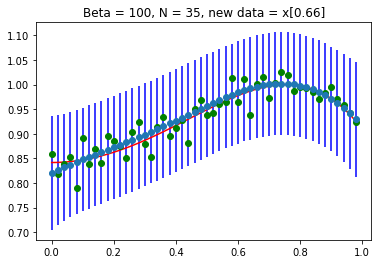

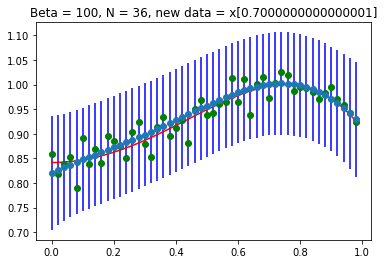

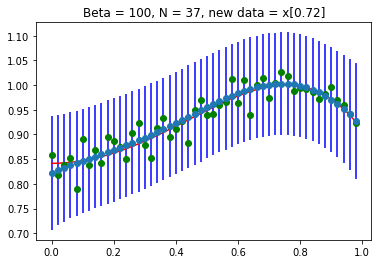

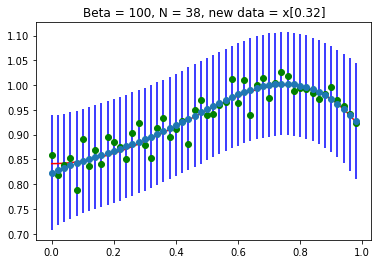

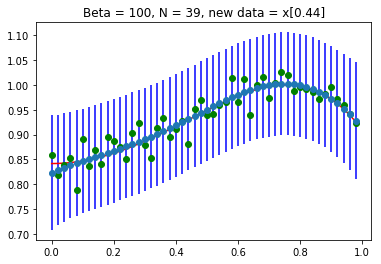

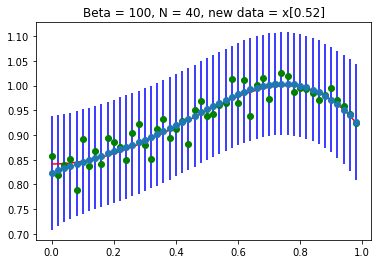

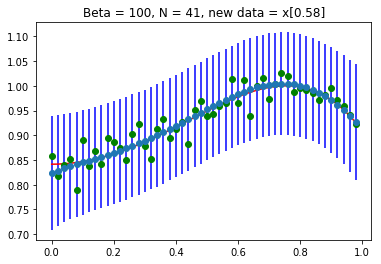

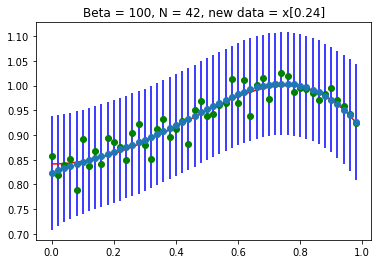

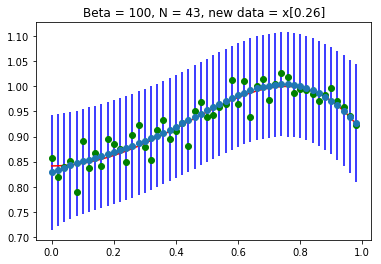

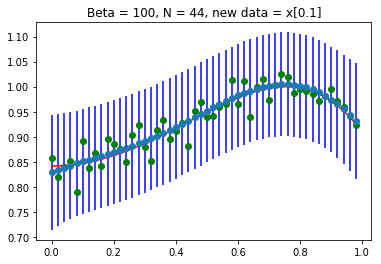

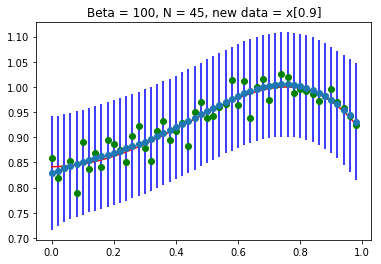

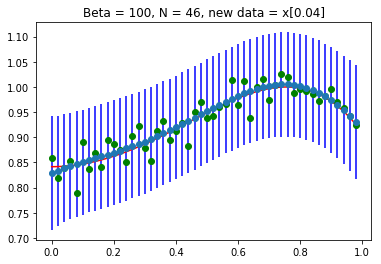

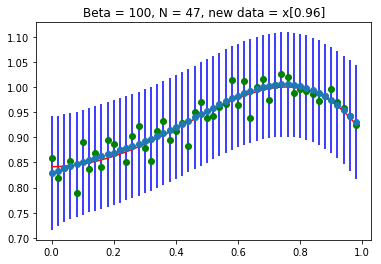

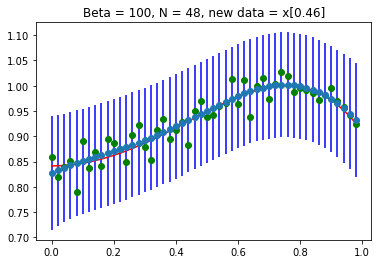

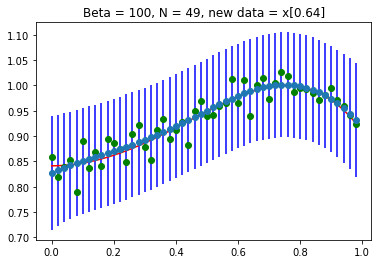

In [69]:
b = 100
update(1.0, 4, 0, 0, x, b, t_bar)

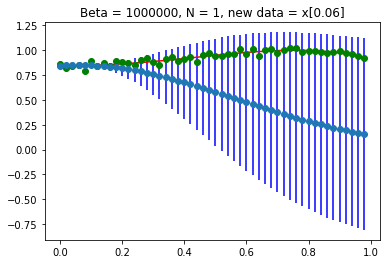

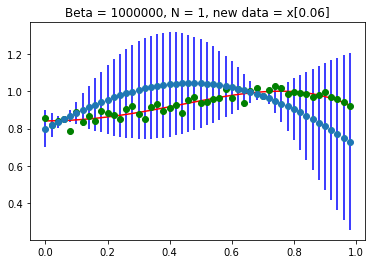

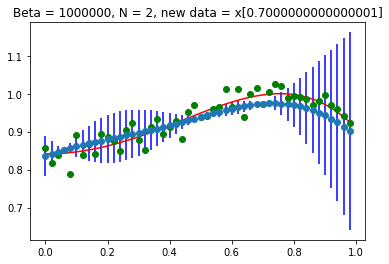

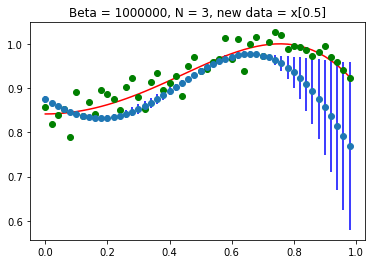

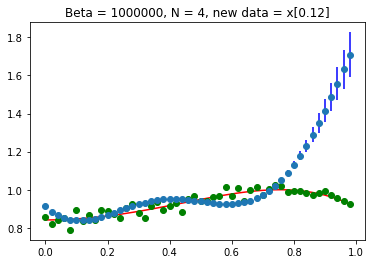

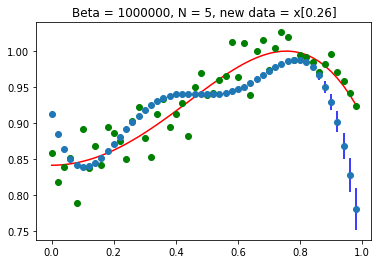

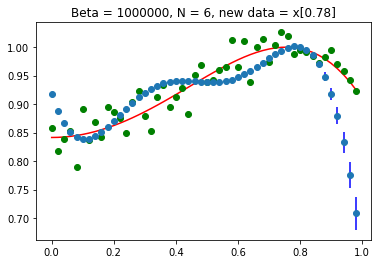

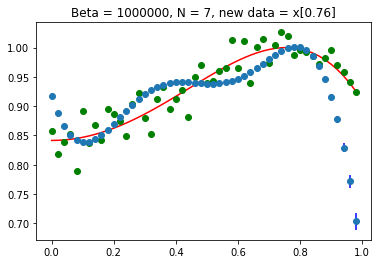

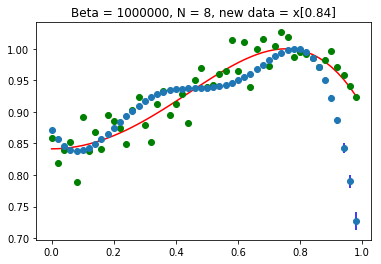

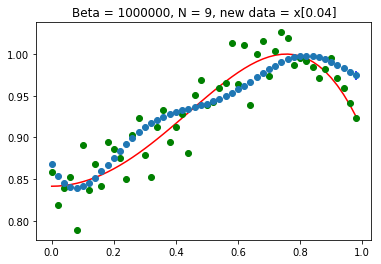

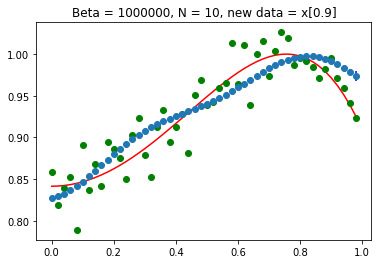

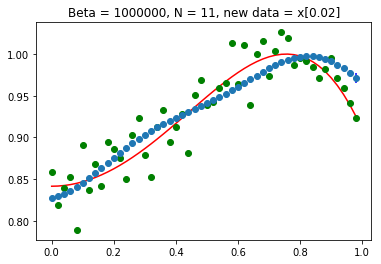

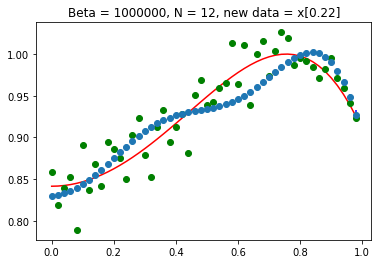

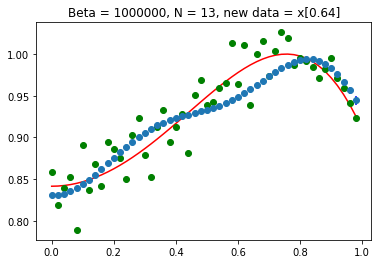

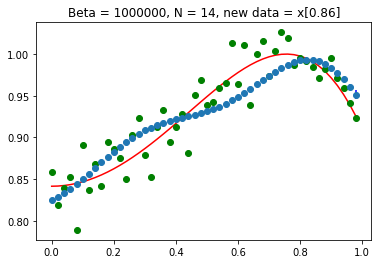

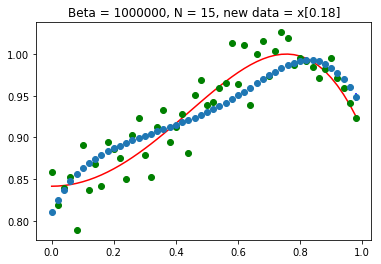

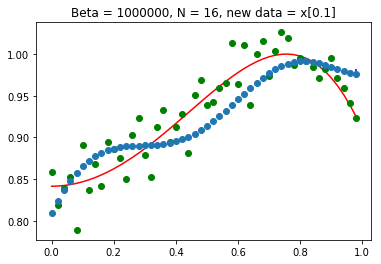

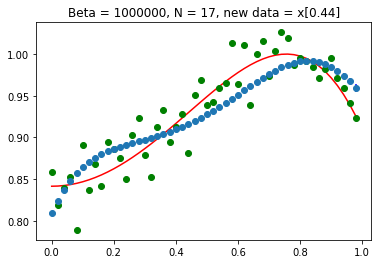

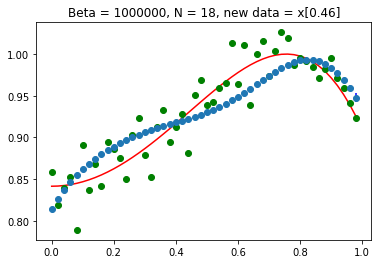

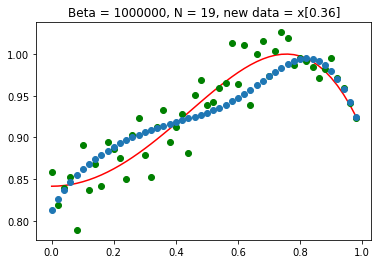

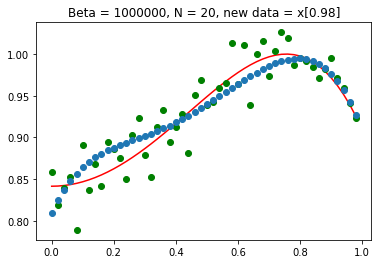

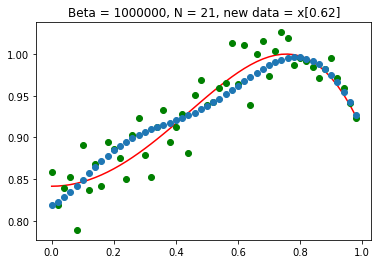

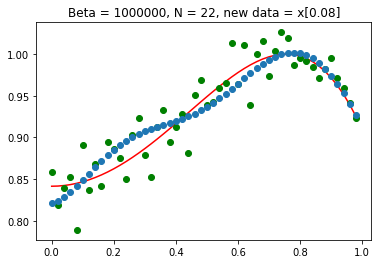

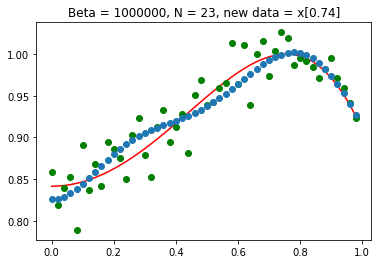

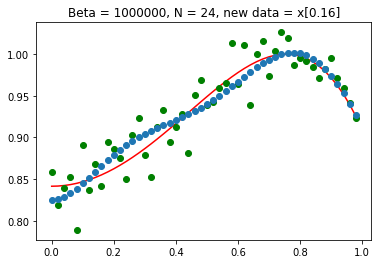

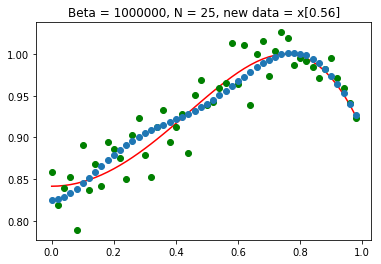

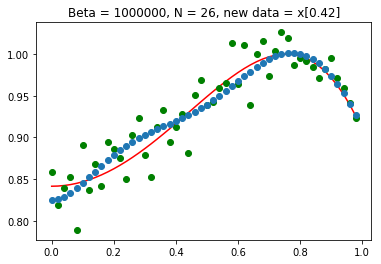

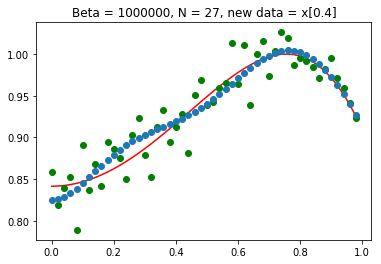

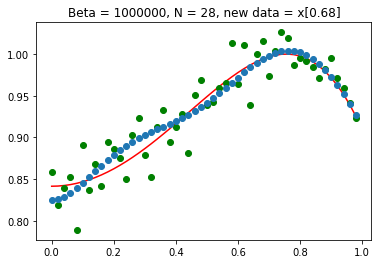

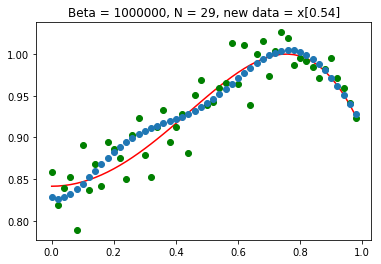

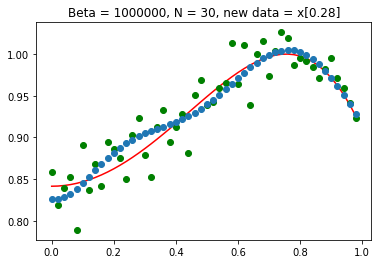

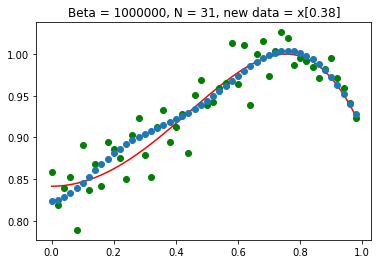

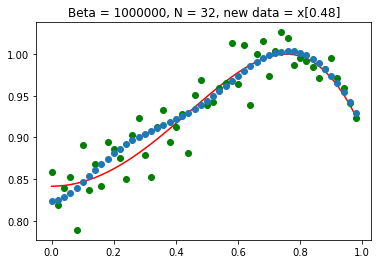

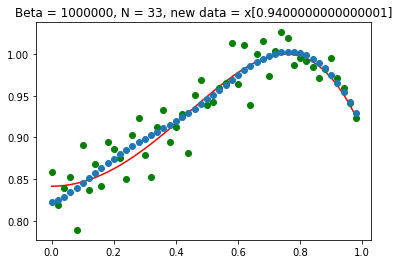

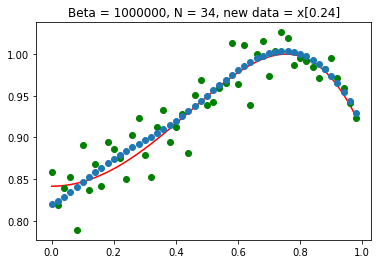

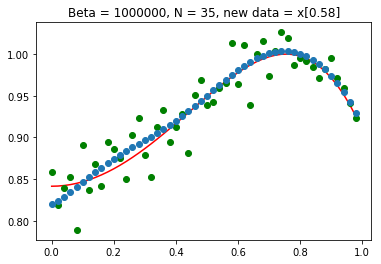

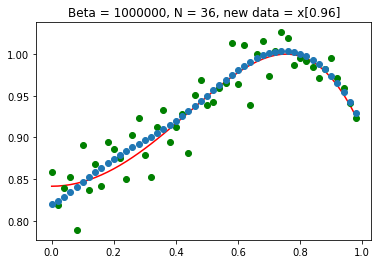

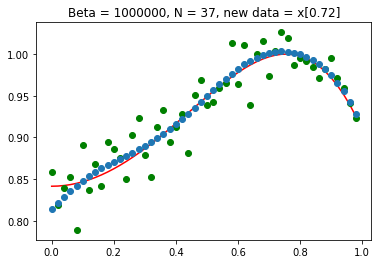

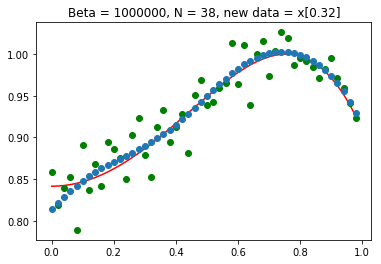

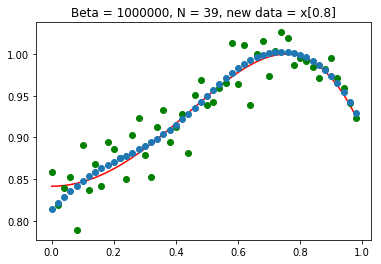

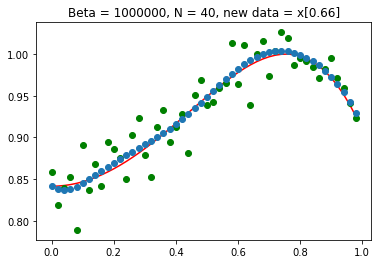

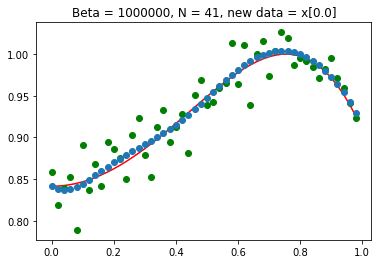

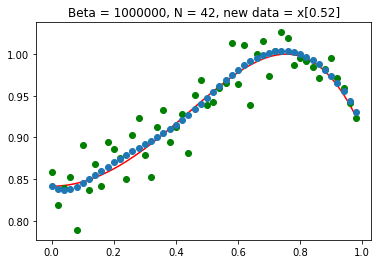

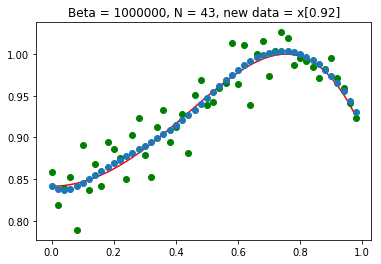

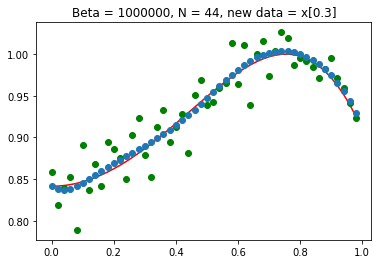

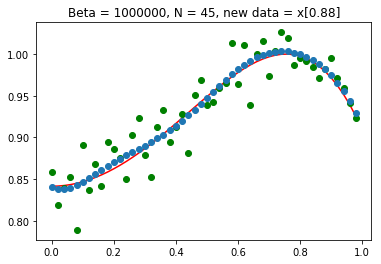

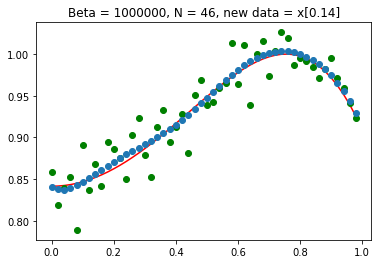

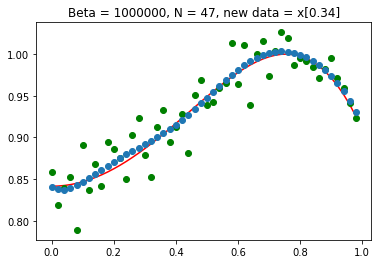

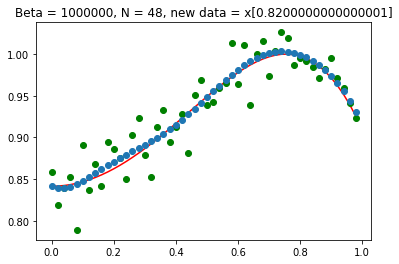

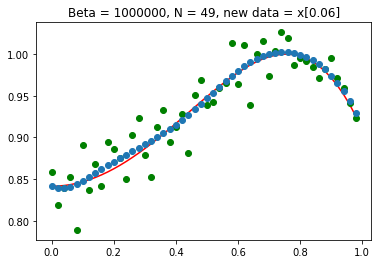

In [70]:
b = 1000000
update(1.0, 4, 0, 0, x, b, t_bar)

In this case, $\frac{1}{\beta}$ is the regularisation constant, 
so the lower the value of $\beta$ and the higher the value of $\frac{1}{\beta}$, the smoother the curve will appear. 

Also, the smaller the value of $\frac{1}{\beta}$, the smaller the uncertainty of the prediction. This is because $c^* \rightarrow k(x^*, x^*)$ as $\frac{1}{\beta} \rightarrow 0$, which means that $|c^*|$ will decrease with a decrease in $\frac{1}{\beta}$, resulting in a decrease in $\Sigma^*$. Since the output of a kernel function is always positive, this means that $\Sigma^* \rightarrow 0$, resulting in the last graph above where there is almost $0$ uncertainty in the prediction.

7. Show your best prediction results for all 50 data one by one:

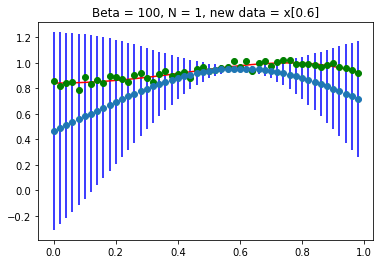

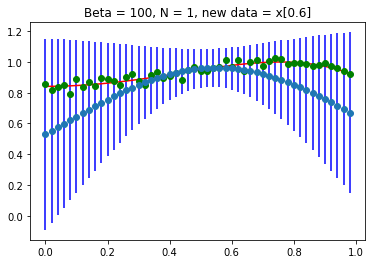

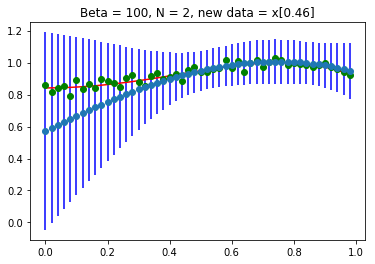

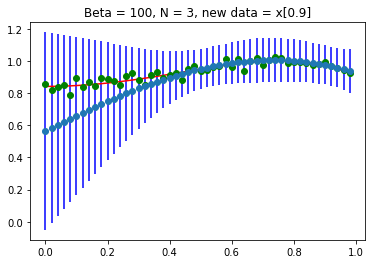

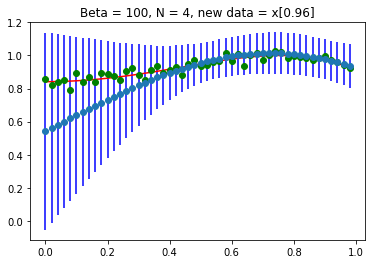

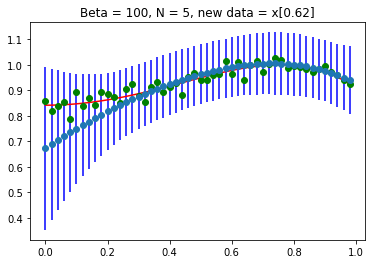

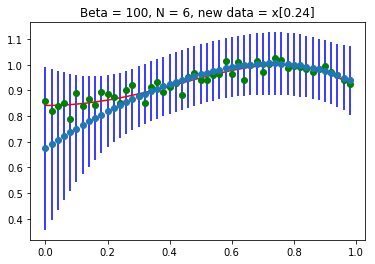

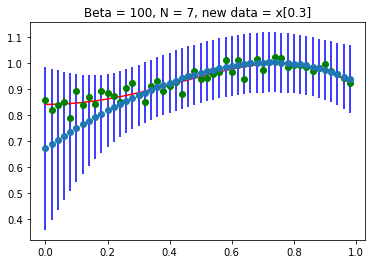

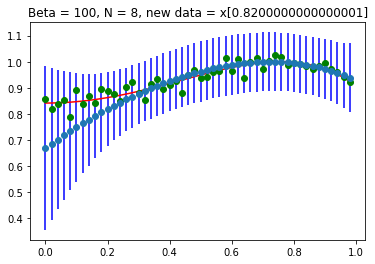

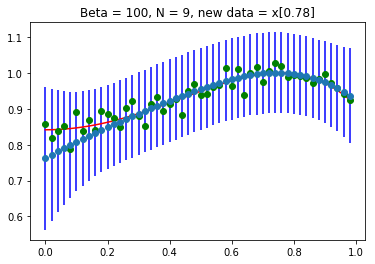

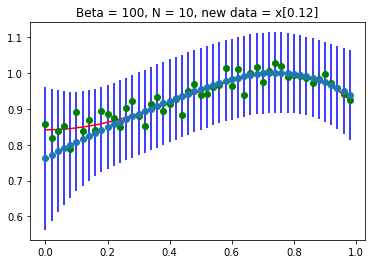

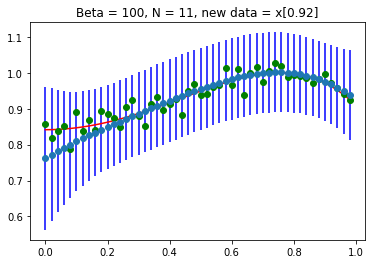

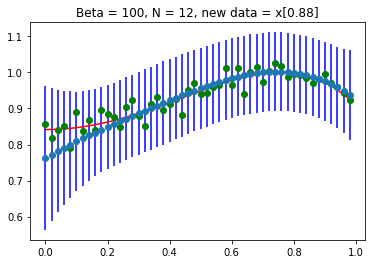

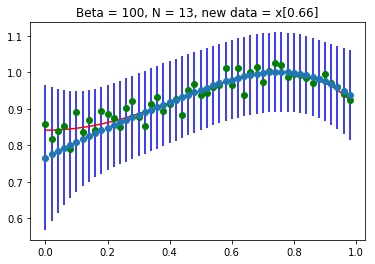

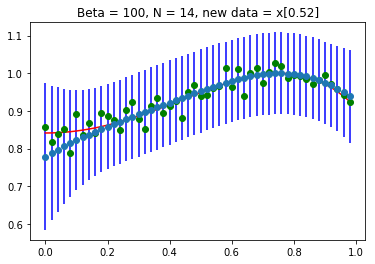

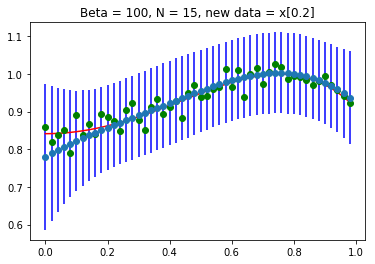

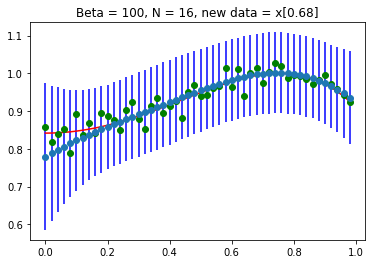

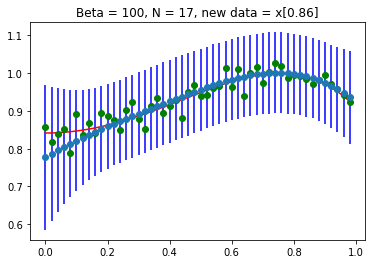

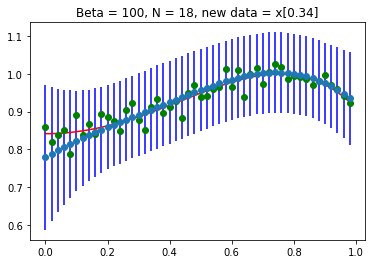

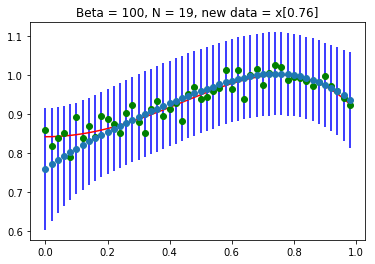

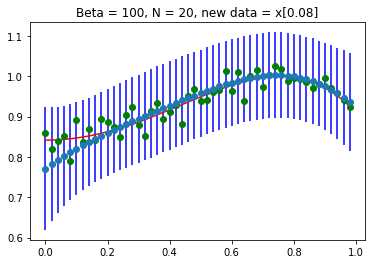

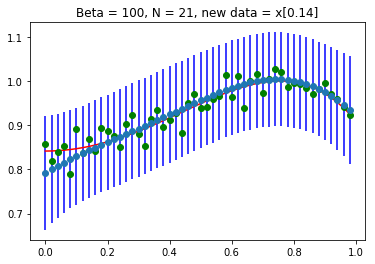

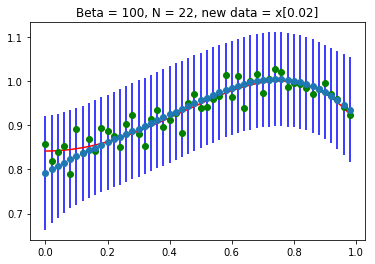

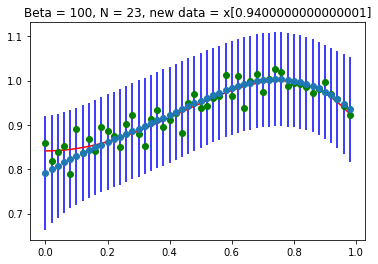

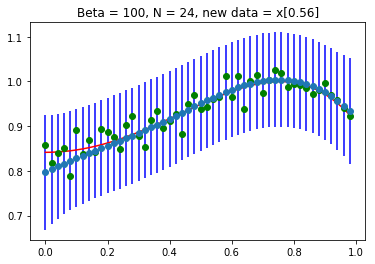

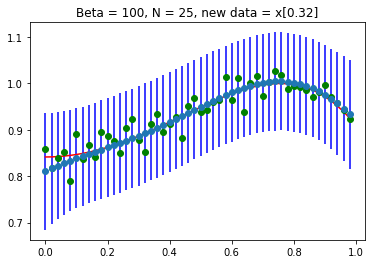

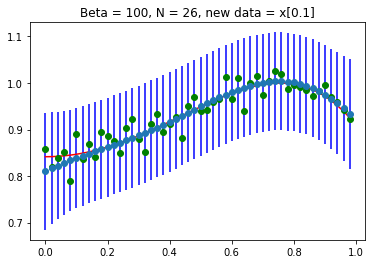

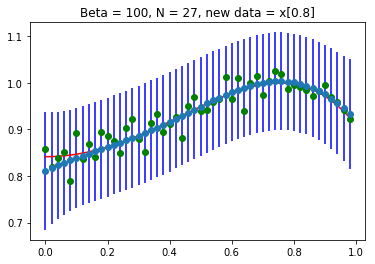

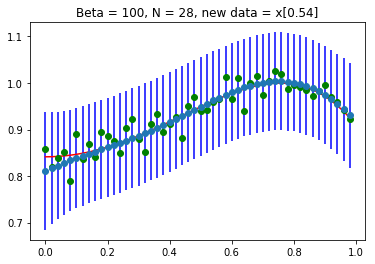

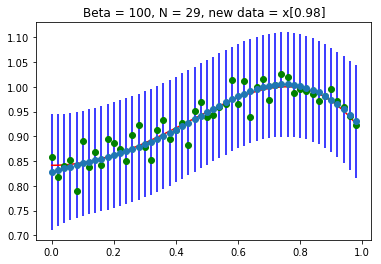

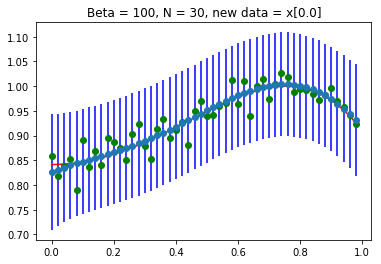

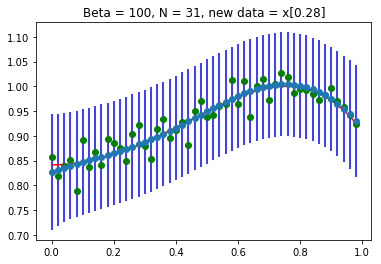

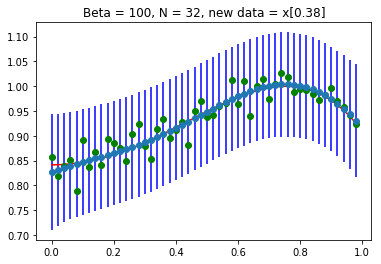

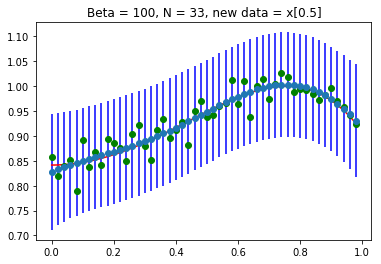

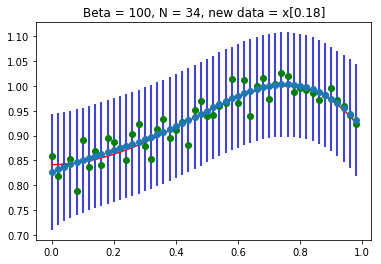

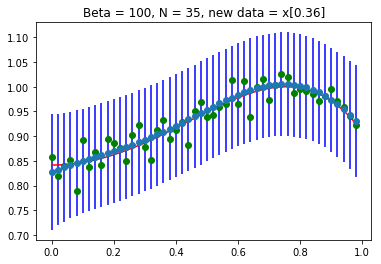

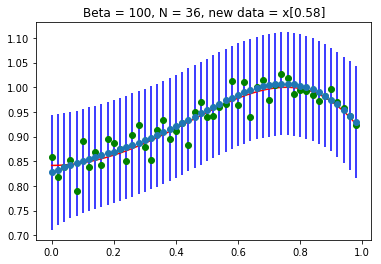

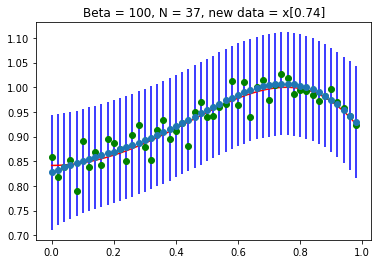

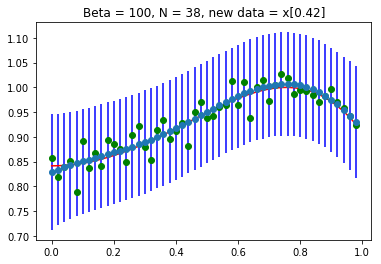

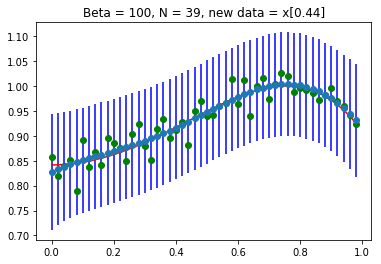

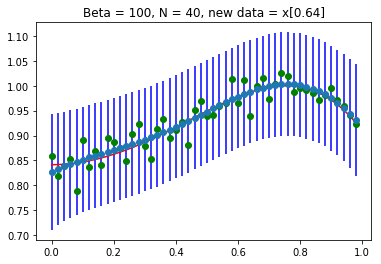

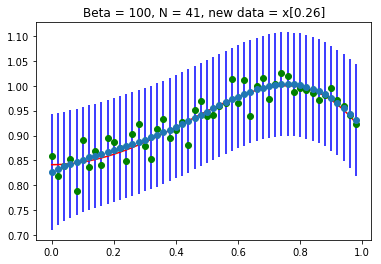

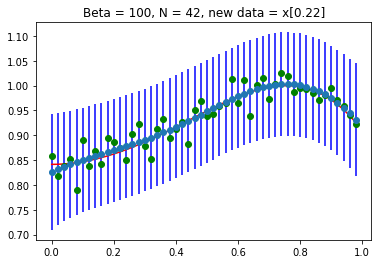

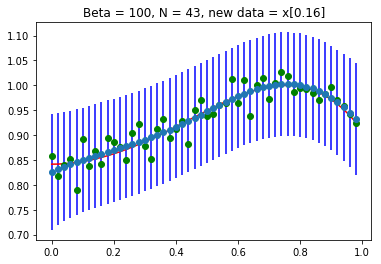

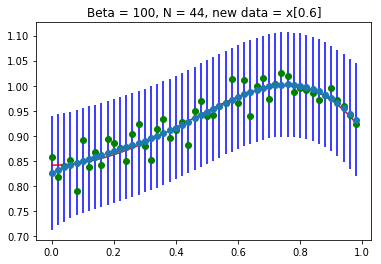

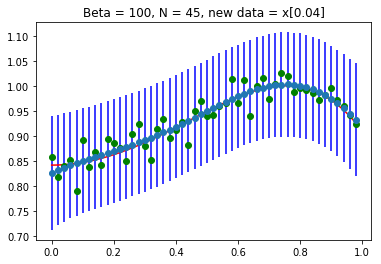

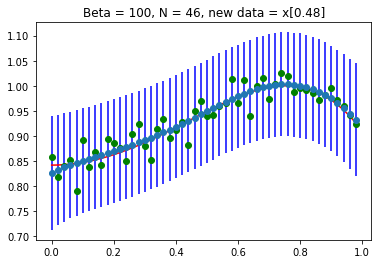

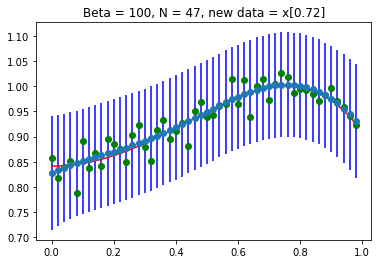

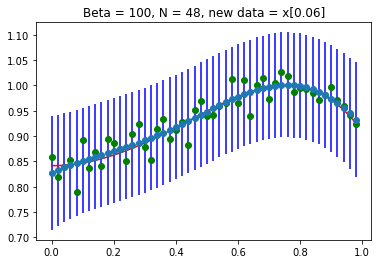

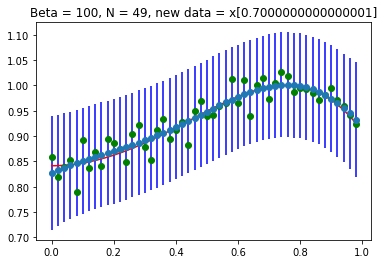

In [71]:
b = 100
update(1.0, 4, 0, 0, x, b, t_bar)

8. Change the kernel's parameters, thetas: (1.0, 64.0, 10.0, 5.0), and show the results.
9. Explain what the effects of changing to this kernel on the prediction.

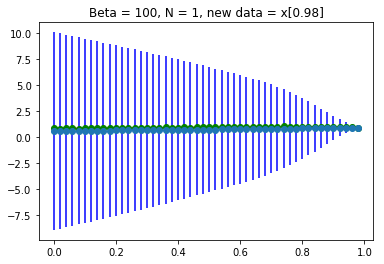

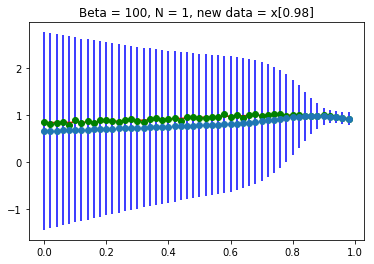

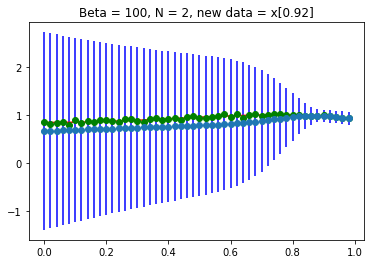

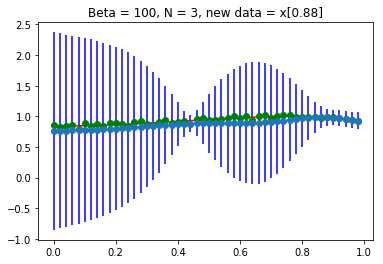

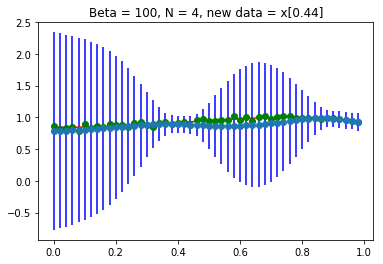

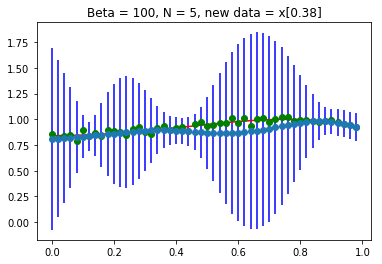

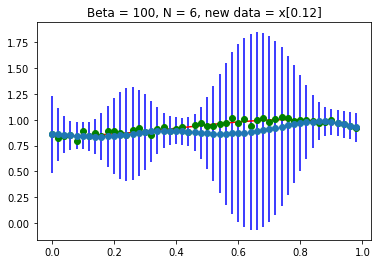

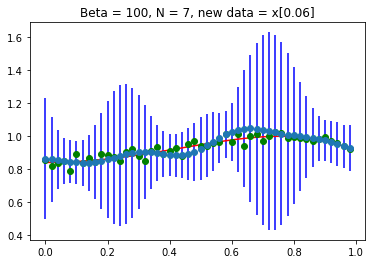

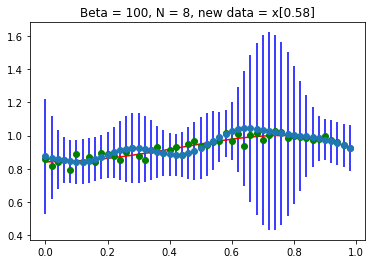

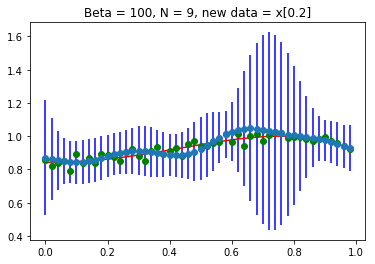

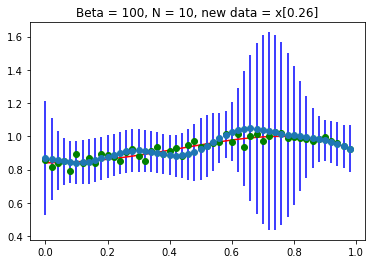

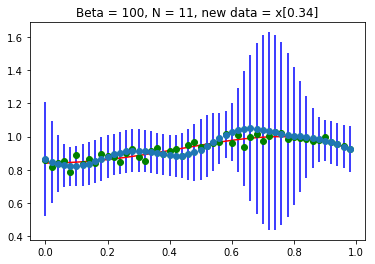

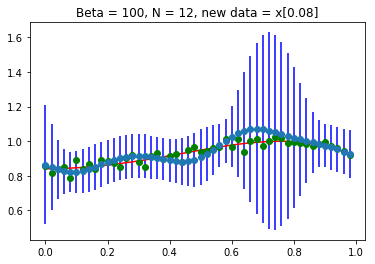

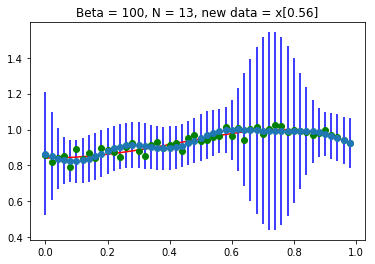

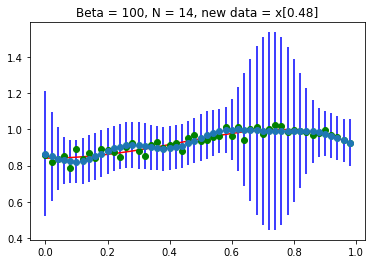

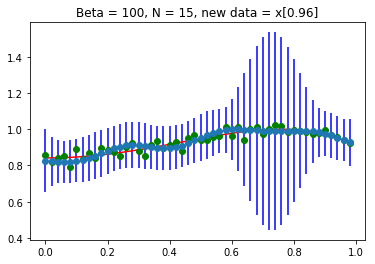

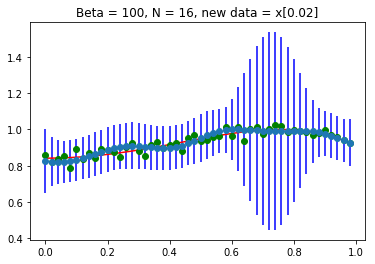

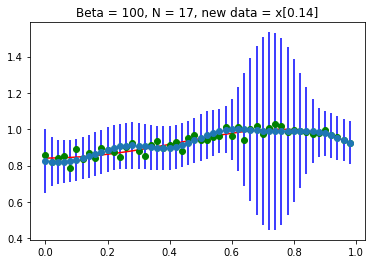

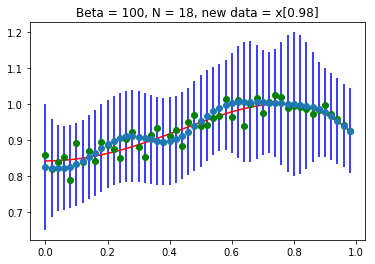

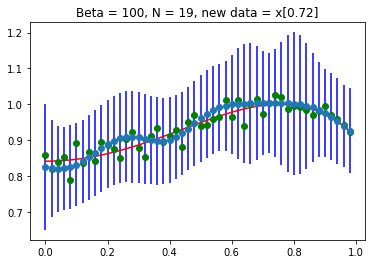

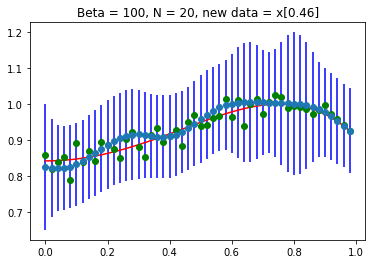

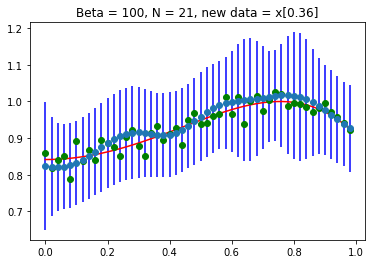

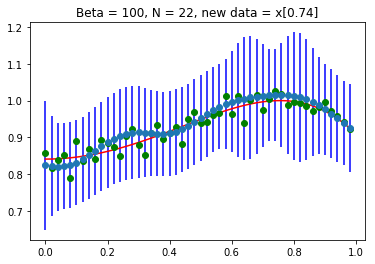

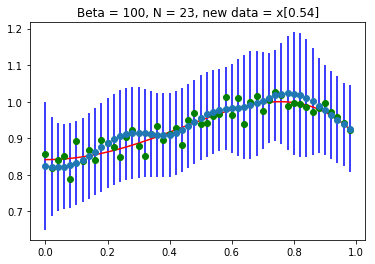

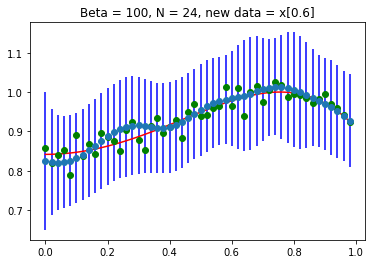

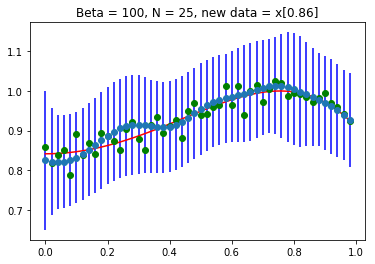

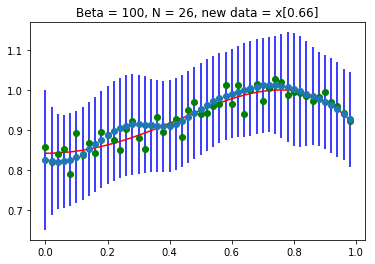

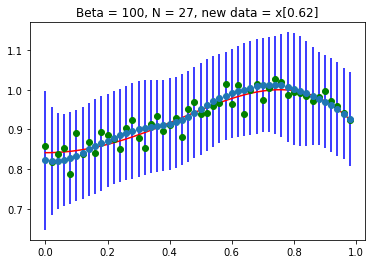

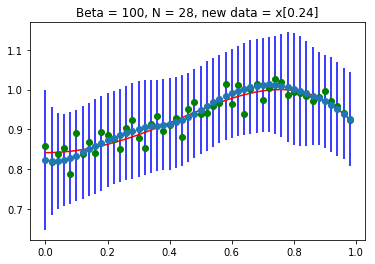

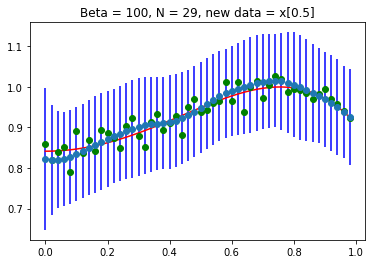

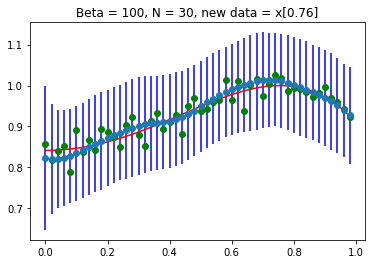

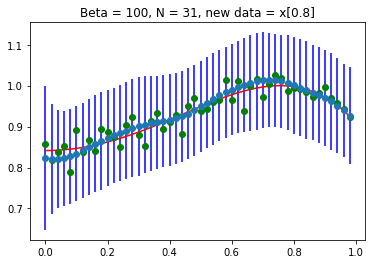

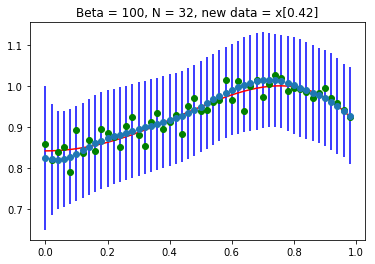

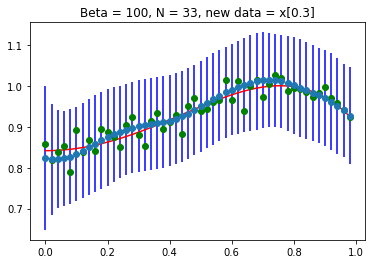

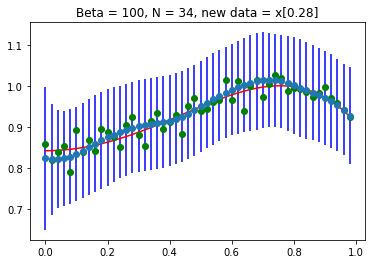

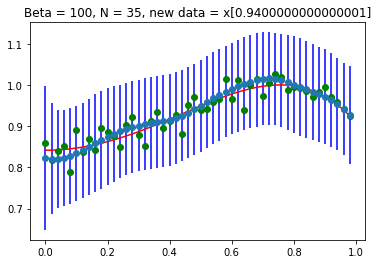

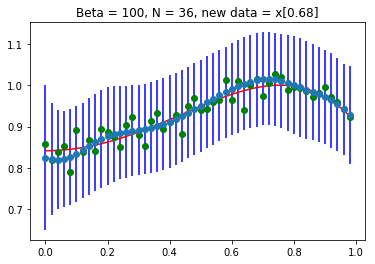

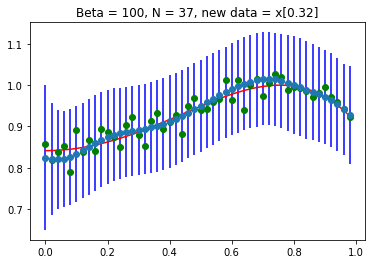

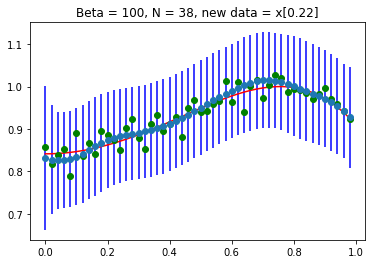

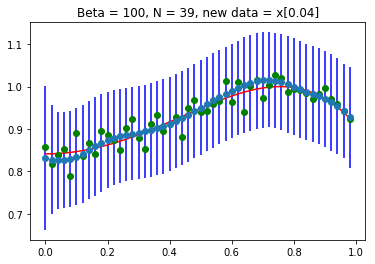

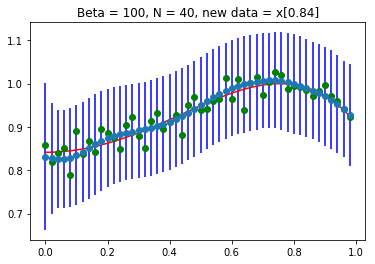

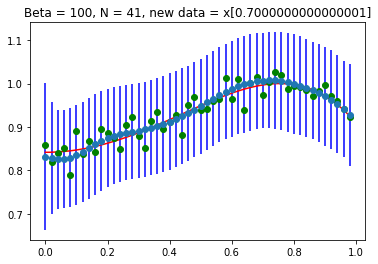

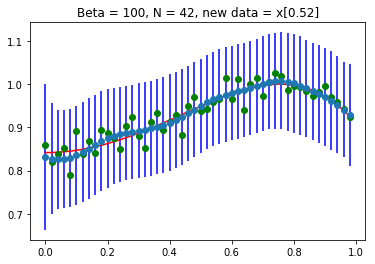

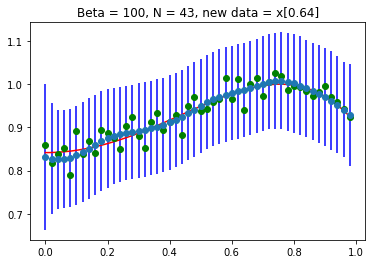

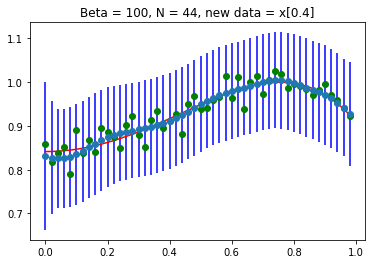

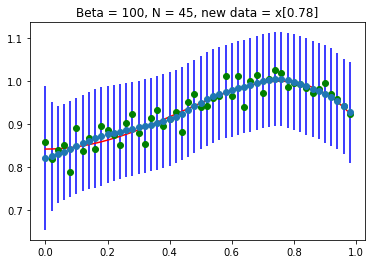

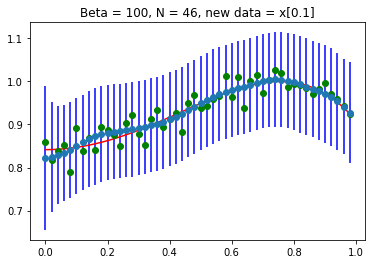

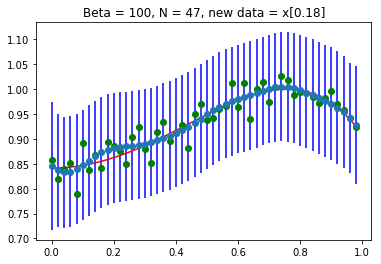

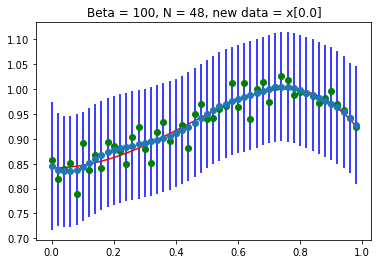

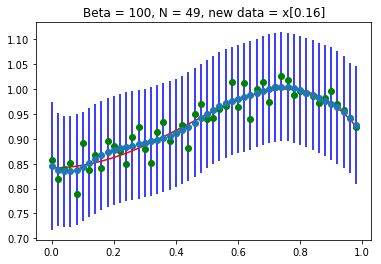

In [72]:
b = 100
update(1.0, 64, 10, 5, x, b, t_bar)

Overfitting occurs. This is because the kernel function is extremely expressive since there is a very large difference in the output of the kernel function relative to the difference in $x_i$ and $x_j$ due to a very large value of $\theta_1$. The first few values of $N$ also lead to very high variations in uncertainty, which again point to the higher expressiveness of the kernel function.

10. Change the kernel's parameters, thetas: (1.0, 0.25, 0.0, 0.0), and show the results.
11. Explain what the effects of changing to this kernel on the prediction.

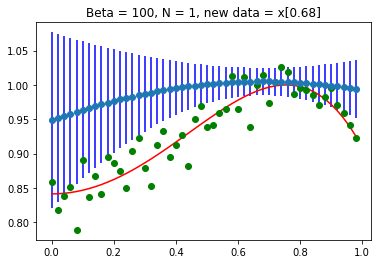

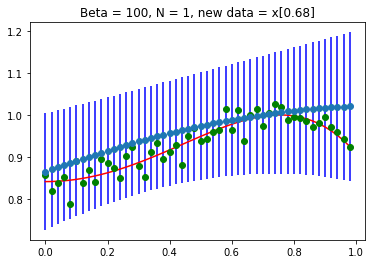

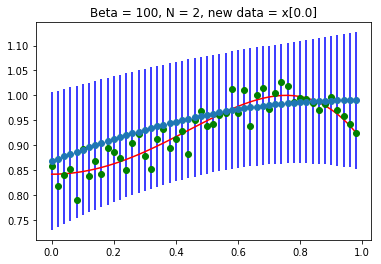

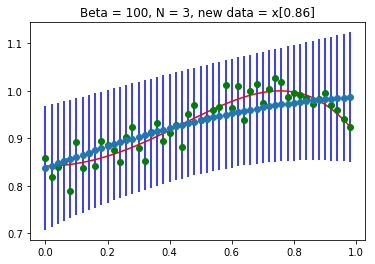

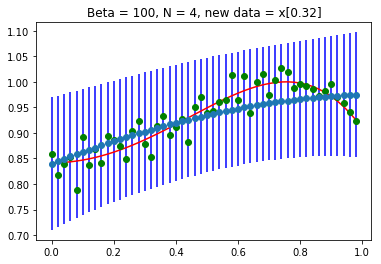

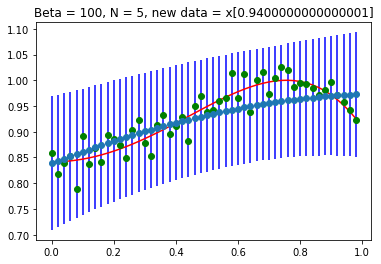

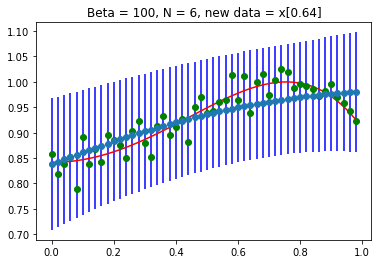

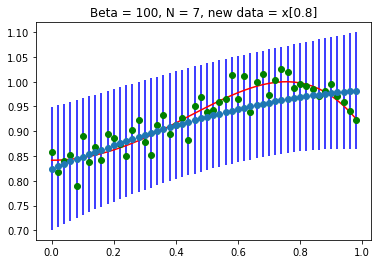

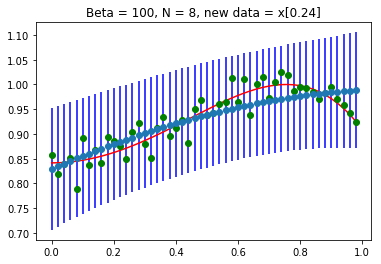

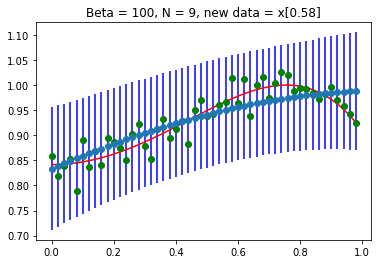

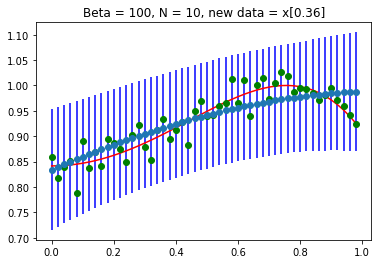

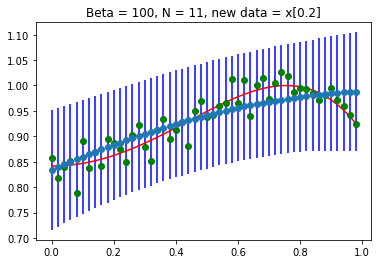

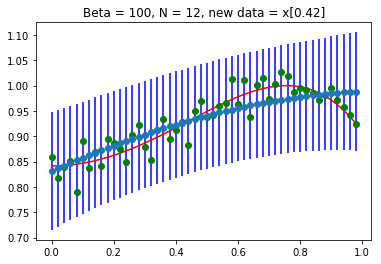

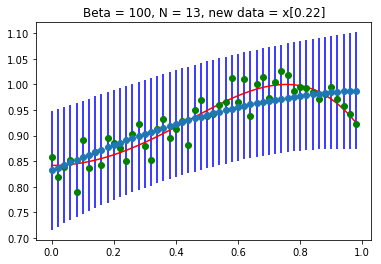

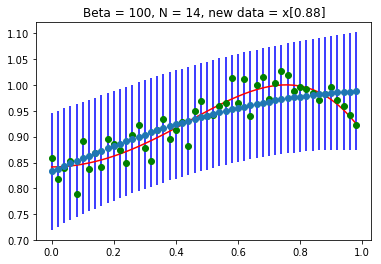

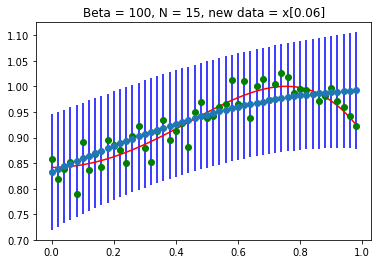

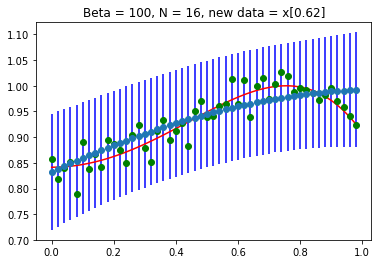

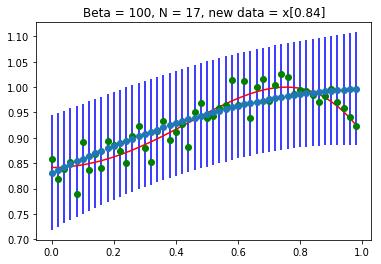

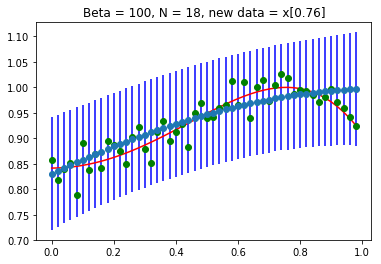

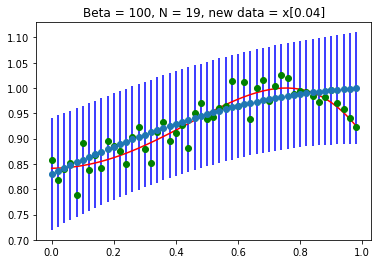

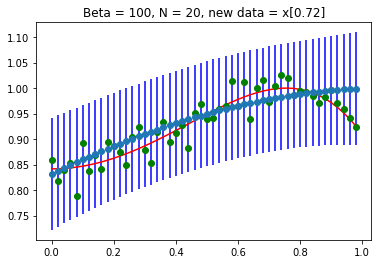

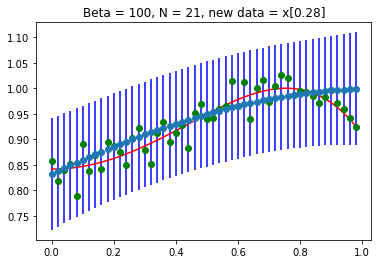

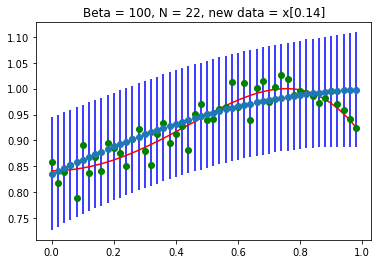

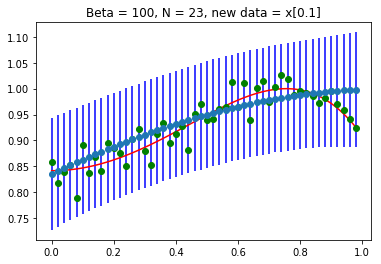

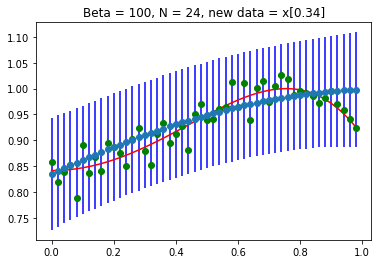

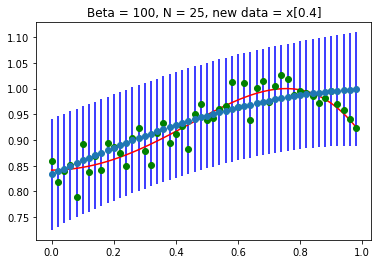

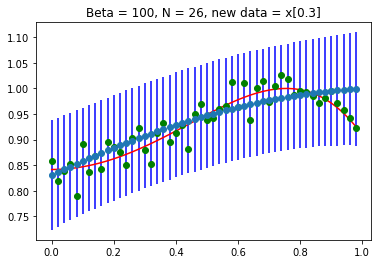

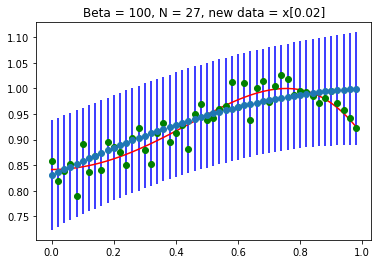

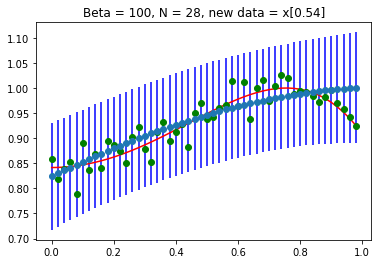

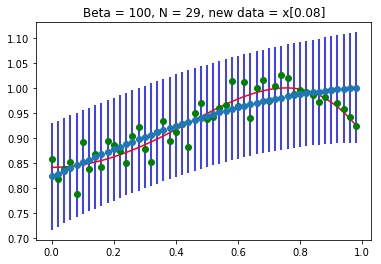

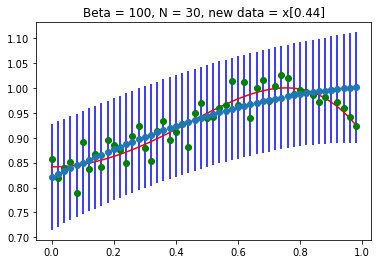

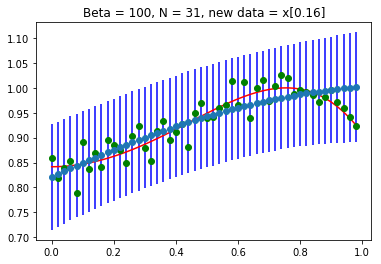

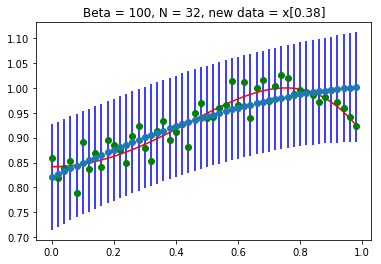

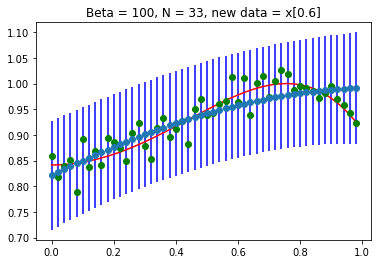

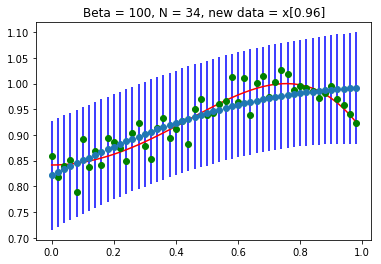

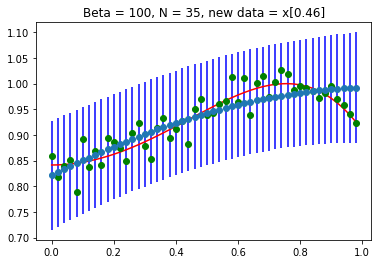

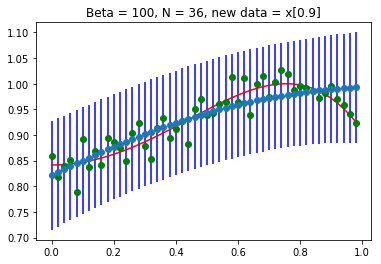

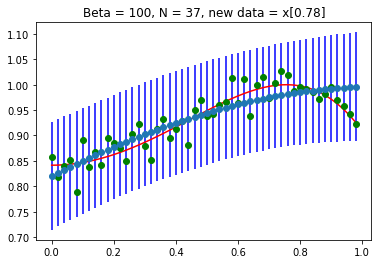

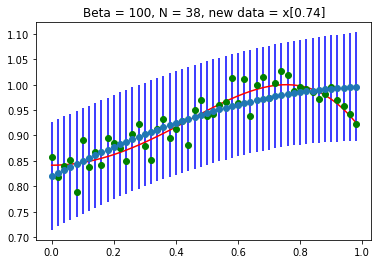

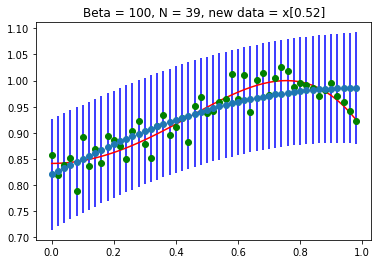

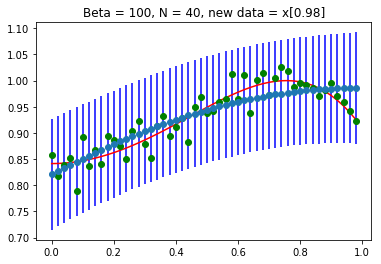

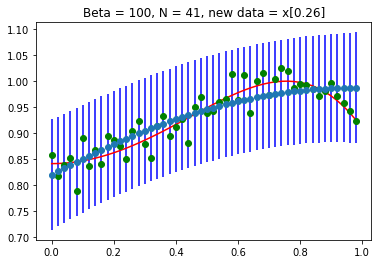

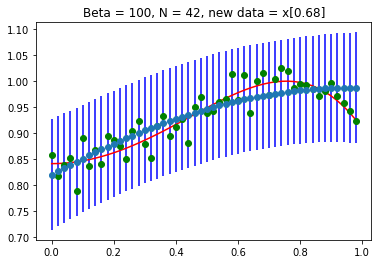

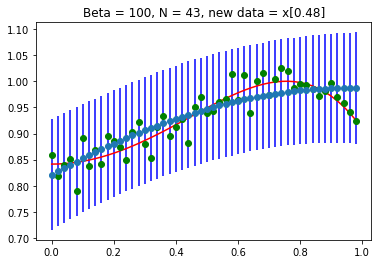

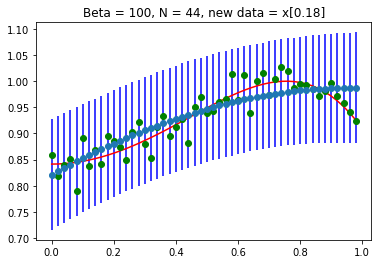

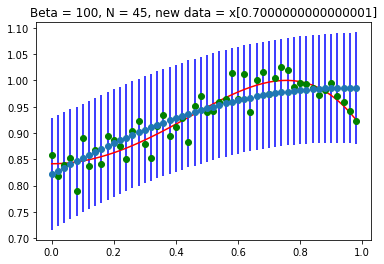

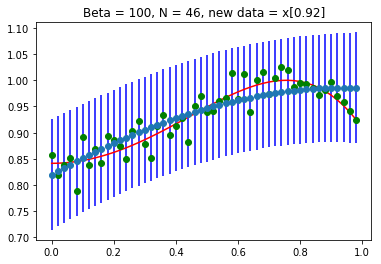

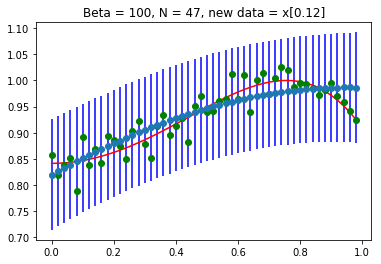

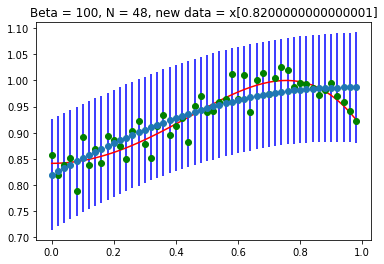

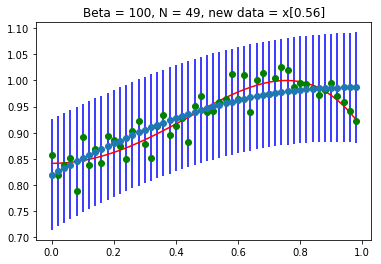

In [74]:
b = 100
update(1.0, 0.25, 0, 0, x, b, t_bar)

Underfitting occurs. This is because the kernel function is not so expressive since there is not much difference in the output of the kernel function relative to the difference in $x_i$ and $x_j$. We can see in the first few values of $N$ that the uncertainty is fluctuating less than in the previous question above as well, which demonstrates the kernel function's lack of expressiveness.